# LSTM Model

### Description

Predicting the stock market is inherently difficult.  However, it does present an interesting and challenging approach for machine learning.  As well, compared to other machine learning tasks, the stock market is unique as it is inherently time series data, rather than several independent events.  This leads to a somewhat different typical approach, for example in choice of train set and test set.

As this project is at the beginning and exploration phase, we chose to use an easily available data set.  We chose a dataset from Kaggle, which used to be found [here](https://www.kaggle.com/timoboz/stock-data-dow-jones) which was accessed in January 2019 of end-of-day data for all stocks in the Dow Jones industrial average.  As of April 2019, unfortunately, the data does not seem to be accessible, though Kaggle contains other Dow Jones stock data, such as [here](https://www.kaggle.com/jmwithro/dow-jones-index-data-set).  Note that all accessed csv files are accessible in this repository.

### Method

This notebook is used to develop a Long-Short Term Memory (LSTM) nerual network model for predicting Dow Jones stocks.  LSTM network layers are designed to "remember" previous input and are used for tasks such as natural language processing where the relationship of data in sequence is important.  The possible appeal for the stock market, where recent history is probably very important is therefore obvious.

We develop the LSTM neural network here using the Keras library, which is built to handle Tensorflow.  For a description of LSTM networks and Keras, see [here](https://adventuresinmachinelearning.com/keras-lstm-tutorial/).

As this project actually involves comparison to several other machine learning methods, it was necessary to develop all methods using a similar data source.  Thus, the Wal-Mart data was randomly chosen as a starting point.  So, this notebook primarily involves building and training a model on the Wal-Mart data file.

### Packages

First, we load important packages.

In [1]:
#import some useful packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

### Data

Now, we can load the Wal-Mart stock data.

In [2]:
#load Walmart Stock Data
filepath = os.path.join('..', 'Resources', 'WMT.csv')
df = pd.read_csv(filepath)
df.head()

,date,open,high,low,close,volume,unadjustedVolume,change,changePercent,vwap,label,changeOverTime
0,2014-01-27,64.7650,64.9747,64.5029,64.7825,9105139,9105139,-0.235889,-0.363,64.7739,"Jan 27, 14",0.000000
1,2014-01-28,64.8786,65.8746,64.7388,65.2368,6035231,6035231,0.454305,0.701,65.3045,"Jan 28, 14",0.007013
2,2014-01-29,65.7785,65.8484,64.7126,64.7388,8440854,8440854,-0.497990,-0.763,61.0517,"Jan 29, 14",-0.000675
3,2014-01-30,65.1232,65.6037,64.9660,65.3067,6742046,6742046,0.567883,0.877,65.2975,"Jan 30, 14",0.008092
4,2014-01-31,64.5816,65.6911,64.3369,65.2455,10665285,10665285,-0.061155,-0.094,65.3223,"Jan 31, 14",0.007147


We get rid of columns we do not need and set the index as the date column.

In [3]:
#drop unnessecary columns
df.drop(['volume', 'unadjustedVolume', 'change', 'changePercent', 'vwap', 'label', 'changeOverTime'], 1, inplace = True)
df.head()

,date,open,high,low,close
0,2014-01-27,64.7650,64.9747,64.5029,64.7825
1,2014-01-28,64.8786,65.8746,64.7388,65.2368
2,2014-01-29,65.7785,65.8484,64.7126,64.7388
3,2014-01-30,65.1232,65.6037,64.9660,65.3067
4,2014-01-31,64.5816,65.6911,64.3369,65.2455


In [4]:
#set index
df.set_index('date', inplace = True)
df.head()

,open,high,low,close
date,,,,
2014-01-27,64.7650,64.9747,64.5029,64.7825
2014-01-28,64.8786,65.8746,64.7388,65.2368
2014-01-29,65.7785,65.8484,64.7126,64.7388
2014-01-30,65.1232,65.6037,64.9660,65.3067
2014-01-31,64.5816,65.6911,64.3369,65.2455


As a demonstration, let's just take a look at the close price over time.

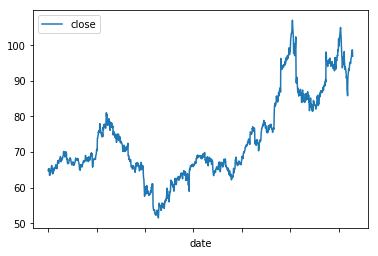

In [5]:
#plot close price
df.plot(y='close')

### Create Train and Test Split Data

We need to create a train/test split.  In most machine learning problems, we want to randomize the points (the different days in our data set) for proper methodology.  In time series problems, where days depend on past points inherently, we take a different approach.  We take the first percentage (preferably at least 70%) as the training set and use the remaining more recent data as the test set.  

For the output, we use the close price of the day.  For the input data, we use a certain window of data to predict a certain point in the future.  For example, we start with a 30 x 4 matrix here (30 days of open/high/low/close prices).  We predict a point one week in the future (5 business days).  As our data set is simply of sequential days the stock exchange is open, we pretend as if holidays and weekends do not exist.

So in this example, we would need sets of 35 days for each data point.  Thus the exact data set size will depend on our sequence lengths and future points.

We now go with this process to develop a train/test split.  Due to the requirements of Keras, we need to first convert data to a Numpy array.

In [6]:
#save data as a matrix
data = df.values
data.shape

(1259, 4)

In [7]:
#save sequence length and time in the future
#we will start with 30 days and 5 days in the future (about 1 month and 1 week)
seq_length = 30
fut_point = 5
features = 4

Now, we can get the input (X) and output (Y) data.

In [8]:
#get X data (30 day sequences)
X = []
#get all sequences up to (sequence length + future point) days out of last point (can then predict last point)
for index in range(len(data) - seq_length - fut_point):
    X.append(data[index: index + seq_length])
#get X as a numpy array
X = np.array(X)
X.shape

(1224, 30, 4)

In [9]:
#get Y data (close price for all days except first (sequence length + future point) days)
y = data[(seq_length + fut_point):, -1]
y.shape

(1224,)

We begin with an 85/15 percent train/test split.

In [10]:
#train/test split of 0.85/0.15
train_split = 0.85
last_row = int(train_split * X.shape[0])
X_train = X[:last_row]
X_test = X[last_row:]
y_train = y[:last_row]
y_test = y[last_row:]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1040, 30, 4)
(184, 30, 4)
(1040,)
(184,)


### Scale Data

We need to normalize this data for machine learning purposes.  We use Scikit-Learn's MinMaxScaler to get a normalized scale from the training data and then apply it to scale both the training and test set data.

In [11]:
#instantiate scalers
X_scaler = MinMaxScaler(feature_range = (-1, 1))
y_scaler = MinMaxScaler(feature_range = (-1, 1))

In [12]:
#reshape data so it can be fit
X_train_reshaped = np.reshape(X_train, (-1, 4))
X_test_reshaped = np.reshape(X_test, (-1, 4))
y_train_reshaped = np.reshape(y_train, (-1, 1))
y_test_reshaped = np.reshape(y_test, (-1, 1))

In [13]:
#fit scalers
X_scaler.fit(X_train_reshaped)
y_scaler.fit(y_train_reshaped)

MinMaxScaler(copy=True, feature_range=(-1, 1))

In [14]:
#transform and rescale
X_train_scaled = np.reshape(X_scaler.transform(X_train_reshaped), X_train.shape)
X_test_scaled = np.reshape(X_scaler.transform(X_test_reshaped), X_test.shape)
y_train_scaled = np.reshape(y_scaler.transform(y_train_reshaped), y_train.shape[0])
y_test_scaled = np.reshape(y_scaler.transform(y_test_reshaped), y_test.shape[0])
X_train_scaled.shape

(1040, 30, 4)

### LSTM model

Now, we build a basic LSTM network model.  We choose to use two different LSTM layers.  After each, we add a Dropout layer.  A dropout layer randomly ignores a certain amount of weights during each training epoch.  Final weights are then weighted by the amount of time each was used in training.  To end, we add a dense neural network layer and then a final layer with a linear output (because we are predicting one close point for each data point).

We begin by importing the required functions and then building the model.

In [15]:
#import layers
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, LSTM

/anaconda3/envs/PythonData/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [37]:
#create an LSTM model
model = Sequential()

#add first LSTM layer and dropout layer
model.add(LSTM(256, return_sequences = True, input_shape = (seq_length, features)))
model.add(Dropout(0.2))

#add second LSTM layer and dropout layer
model.add(LSTM(256, return_sequences = False))
model.add(Dropout(0.2))

#add an reLU layer
model.add(Dense(32, activation = 'relu'))

#add a final layer
model.add(Dense(1, activation = 'linear'))

#compile model
model.compile(loss = 'mse', optimizer = 'adam', metrics = ['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 30, 256)           267264    
_________________________________________________________________
dropout_5 (Dropout)          (None, 30, 256)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                8224      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 800,833
Trainable params: 800,833
Non-trainable params: 0
_________________________________________________________________


We can now fit the model and save it using Keras's save function.

In [38]:
#fit model
model.fit(X_train_scaled, y_train_scaled, epochs = 300, batch_size = 64, validation_split = 0.15, verbose = 1)

Train on 884 samples, validate on 156 samples
Epoch 1/300
884/884 [==============================] - 3s 4ms/step - loss: 0.0414 - acc: 0.0011 - val_loss: 0.0694 - val_acc: 0.0000e+00
Epoch 2/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0087 - acc: 0.0011 - val_loss: 0.0662 - val_acc: 0.0000e+00
Epoch 3/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0066 - acc: 0.0011 - val_loss: 0.0693 - val_acc: 0.0000e+00
Epoch 4/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0056 - acc: 0.0011 - val_loss: 0.0780 - val_acc: 0.0000e+00
Epoch 5/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0054 - acc: 0.0011 - val_loss: 0.0854 - val_acc: 0.0000e+00
Epoch 6/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0055 - acc: 0.0011 - val_loss: 0.0931 - val_acc: 0.0000e+00
Epoch 7/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0053 - acc: 0.0011 - val_loss: 0.1094 - val_acc: 0.0000

884/884 [==============================] - 2s 2ms/step - loss: 0.0040 - acc: 0.0011 - val_loss: 0.1052 - val_acc: 0.0064
Epoch 120/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0042 - acc: 0.0011 - val_loss: 0.0901 - val_acc: 0.0064
Epoch 121/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0037 - acc: 0.0011 - val_loss: 0.0713 - val_acc: 0.0064
Epoch 122/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0038 - acc: 0.0011 - val_loss: 0.0649 - val_acc: 0.0064
Epoch 123/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0037 - acc: 0.0011 - val_loss: 0.0667 - val_acc: 0.0064
Epoch 124/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0037 - acc: 0.0011 - val_loss: 0.1345 - val_acc: 0.0064
Epoch 125/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0039 - acc: 0.0011 - val_loss: 0.0939 - val_acc: 0.0064
Epoch 126/300
884/884 [==============================] - 2s 2ms/step 

Epoch 180/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0034 - acc: 0.0011 - val_loss: 0.0740 - val_acc: 0.0064
Epoch 181/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0036 - acc: 0.0011 - val_loss: 0.0413 - val_acc: 0.0064
Epoch 182/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0034 - acc: 0.0011 - val_loss: 0.0570 - val_acc: 0.0064
Epoch 183/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0040 - acc: 0.0011 - val_loss: 0.0992 - val_acc: 0.0064
Epoch 184/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0040 - acc: 0.0011 - val_loss: 0.0476 - val_acc: 0.0064
Epoch 185/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0035 - acc: 0.0011 - val_loss: 0.0413 - val_acc: 0.0064
Epoch 186/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0035 - acc: 0.0011 - val_loss: 0.0707 - val_acc: 0.0000e+00
Epoch 187/300
884/884 [============================

884/884 [==============================] - 2s 2ms/step - loss: 0.0032 - acc: 0.0011 - val_loss: 0.1371 - val_acc: 0.0064


In [39]:
model.save('first_model.h5')

### Load Model and Make Predictions

We load the model from memory.

In [16]:
model = load_model('first_model.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 30, 256)           267264    
_________________________________________________________________
dropout_5 (Dropout)          (None, 30, 256)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                8224      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 800,833
Trainable params: 800,833
Non-trainable params: 0
_________________________________________________________________


Now we get the scores and root mean square errors.  Essentially, the lower the RMSE, the better the model.

In [17]:
#score models
import math
train_score = model.evaluate(X_train_scaled, y_train_scaled, verbose = 0)
test_score = model.evaluate(X_test_scaled, y_test_scaled, verbose = 0)
train_rmse = math.sqrt(train_score[0])
test_rmse = math.sqrt(test_score[0])
print(f"Training Set- Score: {train_score[0]}, RMSE: {train_rmse}")
print(f"Test Set- Score: {test_score[0]}, RMSE: {test_rmse}")

Training Set- Score: 0.02296979169343383, RMSE: 0.15155788232036574
Test Set- Score: 0.11483484830545343, RMSE: 0.3388729087806422


Now, we make predictions that we can compare to the test set.

In [18]:
#evaluate model on training set and test set
y_train_preds_scaled = model.predict(X_train_scaled)
y_test_preds_scaled = model.predict(X_test_scaled)
y_train_preds_scaled.shape

(1040, 1)

### Plot results
We now wish to visualize our results.

First, we need to denormalize.

In [19]:
#rescale results
y_train_preds_denormed = y_scaler.inverse_transform(y_train_preds_scaled)
y_test_preds_denormed = y_scaler.inverse_transform(y_test_preds_scaled)

Now, we can reshape to the same shape as the training and test sets.

In [20]:
#reshape results for plotting
y_train_preds = np.reshape(y_train_preds_denormed, y_train.shape[0])
y_test_preds = np.reshape(y_test_preds_denormed, y_test.shape[0])
y_train_preds.shape

(1040,)

Now, we can plot the results.

In [21]:
#create x arrays (just day indices)
days1 = np.arange(len(y_train))
days2 = np.arange(len(y_train), len(y_train) + len(y_test))

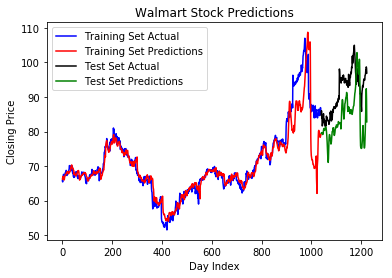

In [22]:
#plot
fig, ax = plt.subplots()
ax.plot(days1, y_train, 'b', label = 'Training Set Actual')
ax.plot(days1, y_train_preds, 'r', label = 'Training Set Predictions')
ax.plot(days2, y_test, 'k', label = 'Test Set Actual')
ax.plot(days2, y_test_preds, 'g', label = 'Test Set Predictions')
ax.legend()
ax.set_title('Walmart Stock Predictions')
ax.set_xlabel('Day Index')
ax.set_ylabel('Closing Price')
plt.show()

We can also plot only the test set.

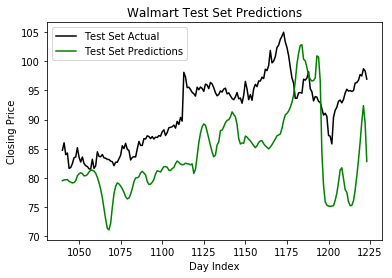

In [23]:
#plot test set only
fig2, ax2 = plt.subplots()
ax2.plot(days2, y_test, 'k', label = 'Test Set Actual')
ax2.plot(days2, y_test_preds, 'g', label = 'Test Set Predictions')
ax2.legend()
ax2.set_title('Walmart Test Set Predictions')
ax2.set_xlabel('Day Index')
ax2.set_ylabel('Closing Price')
plt.show()

We can see that we can get the general trend somewhat OK, though the end is very bad and there is a persistent magnitude error.  This is probably due to the fact that the latest stock prices were all higher than the earliest part of the training set.

### Functions for Arbitrary Size, Number of Neurons, and Future Time Point

We might wish to train the model on different input lengths and future time points, or to train the hyperparameters of the model.  In this case, it is convenient to have functions that allow easy variation of such variables.

We begin with a function for train/test splits.

In [16]:
#function to create training and test data from a dataframe
def train_test_splitter(df, seq_length, fut_point, train_split):
    #save data as a matrix
    data = df.values
    
    #save number of features
    features = data.shape[1]
    
    #get X data (30 day sequences)
    X = []
    #get all sequences up to (sequence length + future point) days out of last point (can then predict last point)
    for index in range(len(data) - seq_length - fut_point):
        X.append(data[index: index + seq_length])
    #get X as a numpy array
    X = np.array(X)
    
    #get Y data (close price for all days except first (sequence length + future point) days)
    y = data[(seq_length + fut_point):, -1]
    
    #create train/test splits using chosing training split (between 0 and 1)
    last_row = int(train_split * X.shape[0])
    X_train = X[:last_row]
    X_test = X[last_row:]
    y_train = y[:last_row]
    y_test = y[last_row:]
    return X_train, X_test, y_train, y_test

In [25]:
#test function with 180 days sequence and 80 days future point
X_train2, X_test2, y_train2, y_test2 = train_test_splitter(df, 180, 80, 0.85)

We now create a function to handle normalization.

In [17]:
#function to create scaled data and scalers
def create_scalers_and_normalize(X_train, X_test, y_train, y_test):
    #instantiate scalers
    X_scaler = MinMaxScaler(feature_range = (-1, 1))
    y_scaler = MinMaxScaler(feature_range = (-1, 1))
    
    #get number of features
    features = X_train.shape[2]
    
    #reshape data so it can be fit
    X_train_reshaped = np.reshape(X_train, (-1, features))
    X_test_reshaped = np.reshape(X_test, (-1, features))
    y_train_reshaped = np.reshape(y_train, (-1, 1))
    y_test_reshaped = np.reshape(y_test, (-1, 1))
    
    #fit scalers
    X_scaler.fit(X_train_reshaped)
    y_scaler.fit(y_train_reshaped)
    
    #transform and rescale
    X_train_scaled = np.reshape(X_scaler.transform(X_train_reshaped), X_train.shape)
    X_test_scaled = np.reshape(X_scaler.transform(X_test_reshaped), X_test.shape)
    y_train_scaled = np.reshape(y_scaler.transform(y_train_reshaped), y_train.shape[0])
    y_test_scaled = np.reshape(y_scaler.transform(y_test_reshaped), y_test.shape[0])
    
    return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, X_scaler, y_scaler

In [27]:
X_train_scaled2, X_test_scaled2, y_train_scaled2, y_test_scaled2, X_scaler2, y_scaler2 = create_scalers_and_normalize(
    X_train2, X_test2, y_train2, y_test2)

Now we create and test a function to create an LSTM model.

In [18]:
#create an LSTM model with different neuron sizes
def create_generic_LSTM_model(neurons, dropout, seq_length, features):
    #create an LSTM model
    model = Sequential()

    #add first LSTM layer and dropout layer
    model.add(LSTM(neurons[0], return_sequences = True, input_shape = (seq_length, features)))
    model.add(Dropout(0.2))

    #add second LSTM layer and dropout layer
    model.add(LSTM(neurons[1], return_sequences = False))
    model.add(Dropout(0.2))

    #add an reLU layer
    model.add(Dense(neurons[2], activation = 'relu'))

    #add a final layer
    model.add(Dense(1, activation = 'linear'))

    #compile model
    model.compile(loss = 'mse', optimizer = 'adam', metrics = ['accuracy'])

    return model

In [29]:
#test function
new_model = create_generic_LSTM_model([256, 256, 32], 0.2, 180, 4)

In [60]:
#save model
new_model.save('second_model.h5')

In [30]:
#load model
new_model = load_model('second_model.h5')

Now, we can create and test a function that loads a pre-trained model and makes predictions.

In [19]:
#function to evaluate score and return predictions for a given model path
import math
def make_preds(model_path, X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, y_scaler):
    #load model
    model = load_model(model_path)
    
    #score models
    train_score = model.evaluate(X_train_scaled, y_train_scaled, verbose = 0)
    test_score = model.evaluate(X_test_scaled, y_test_scaled, verbose = 0)
    train_rmse = math.sqrt(train_score[0])
    test_rmse = math.sqrt(test_score[0])
    print(f"Training Set- Score: {train_score[0]}, RMSE: {train_rmse}")
    print(f"Test Set- Score: {test_score[0]}, RMSE: {test_rmse}")
    
    #evaluate model on training set and test set
    y_train_preds_scaled = model.predict(X_train_scaled)
    y_test_preds_scaled = model.predict(X_test_scaled)
    
    #rescale results
    y_train_preds_denormed = y_scaler.inverse_transform(y_train_preds_scaled)
    y_test_preds_denormed = y_scaler.inverse_transform(y_test_preds_scaled)
    
    #reshape results for plotting
    y_train_preds = np.reshape(y_train_preds_denormed, len(y_train_scaled))
    y_test_preds = np.reshape(y_test_preds_denormed, len(y_test_scaled))
    
    return y_train_preds, y_test_preds, train_score, test_score

In [32]:
#test function
y_train_preds, y_test_preds, train_score, test_score =  make_preds('first_model.h5', X_train_scaled, 
                                                                   X_test_scaled, y_train_scaled, y_test_scaled, 
                                                                   y_scaler)

Training Set- Score: 0.02296979169343383, RMSE: 0.15155788232036574
Test Set- Score: 0.11483484830545343, RMSE: 0.3388729087806422


Now, we can create a function that handles everything through predictions.

In [20]:
#function to create, compile, fit a model, and make predictions
def fit_generic_LSTM_model(df, seq_length, fut_point, train_split, neurons, dropout, epochs, batch_size, 
                           validation_split, model_path):
    
    #get train/test split
    X_train, X_test, y_train, y_test = train_test_splitter(df, seq_length, fut_point, train_split)
    
    #get number of features
    features = X_train.shape[2]
    
    #get scalers and normalized data
    X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, X_scaler, y_scaler = create_scalers_and_normalize(
        X_train, X_test, y_train, y_test)
    
    #create model
    model = create_generic_LSTM_model(neurons, dropout, seq_length, features)
    
    #fit model
    model.fit(X_train_scaled, y_train_scaled, epochs = epochs, 
              batch_size = batch_size, validation_split = validation_split, verbose = 1)
    
    #save model
    model.save(model_path)
    
    #evaluate model and get predictions
    y_train_preds, y_test_preds, train_score, test_score = make_preds(model_path, 
                                                                      X_train_scaled, X_test_scaled, 
                                                                      y_train_scaled, y_test_scaled, y_scaler)
    
    #return necessary variables to create predictions
    return y_train, y_test, y_train_preds, y_test_preds, train_score, test_score

In [49]:
#test function
seq_length = 180
fut_point = 80
train_split = 0.85
neurons = [256, 256, 32]
epochs = 300
batch_size = 64
validation_split = 0.15
dropout = 0.2
model_path = 'third_model.h5'
y_train3, y_test3, y_train_preds3, y_test_preds3, train_score3, test_score3 = fit_generic_LSTM_model(df, 
                                                                                                     seq_length, 
                                                                                                     fut_point, 
                                                                                                     train_split, 
                                                                                                     neurons, 
                                                                                                     dropout, 
                                                                                                     epochs, 
                                                                                                     batch_size,
                                                                                                     validation_split, 
                                                                                                     model_path)

Train on 721 samples, validate on 128 samples
Epoch 1/300
721/721 [==============================] - 13s 18ms/step - loss: 0.1062 - acc: 0.0000e+00 - val_loss: 0.2903 - val_acc: 0.0000e+00
Epoch 2/300
721/721 [==============================] - 9s 13ms/step - loss: 0.0737 - acc: 0.0000e+00 - val_loss: 0.3066 - val_acc: 0.0000e+00
Epoch 3/300
721/721 [==============================] - 9s 13ms/step - loss: 0.0733 - acc: 0.0000e+00 - val_loss: 0.2910 - val_acc: 0.0000e+00
Epoch 4/300
721/721 [==============================] - 10s 13ms/step - loss: 0.0699 - acc: 0.0000e+00 - val_loss: 0.2854 - val_acc: 0.0000e+00
Epoch 5/300
721/721 [==============================] - 9s 13ms/step - loss: 0.0704 - acc: 0.0000e+00 - val_loss: 0.3028 - val_acc: 0.0000e+00
Epoch 6/300
721/721 [==============================] - 9s 13ms/step - loss: 0.0708 - acc: 0.0000e+00 - val_loss: 0.2989 - val_acc: 0.0000e+00
Epoch 7/300
721/721 [==============================] - 9s 13ms/step - loss: 0.0703 - acc: 0.0000e+00

721/721 [==============================] - 9s 12ms/step - loss: 0.0332 - acc: 0.0014 - val_loss: 1.6586 - val_acc: 0.0000e+00
Epoch 117/300
721/721 [==============================] - 9s 13ms/step - loss: 0.0291 - acc: 0.0014 - val_loss: 2.0963 - val_acc: 0.0000e+00
Epoch 118/300
721/721 [==============================] - 9s 12ms/step - loss: 0.0283 - acc: 0.0014 - val_loss: 2.2332 - val_acc: 0.0000e+00
Epoch 119/300
721/721 [==============================] - 9s 12ms/step - loss: 0.0262 - acc: 0.0014 - val_loss: 2.7511 - val_acc: 0.0000e+00
Epoch 120/300
721/721 [==============================] - 9s 12ms/step - loss: 0.0217 - acc: 0.0014 - val_loss: 2.3657 - val_acc: 0.0000e+00
Epoch 121/300
721/721 [==============================] - 9s 12ms/step - loss: 0.0336 - acc: 0.0014 - val_loss: 1.4498 - val_acc: 0.0000e+00
Epoch 122/300
721/721 [==============================] - 9s 12ms/step - loss: 0.0273 - acc: 0.0014 - val_loss: 0.9754 - val_acc: 0.0000e+00
Epoch 123/300
721/721 [===========

721/721 [==============================] - 9s 13ms/step - loss: 0.0223 - acc: 0.0014 - val_loss: 0.5446 - val_acc: 0.0000e+00
Epoch 232/300
721/721 [==============================] - 9s 13ms/step - loss: 0.0261 - acc: 0.0014 - val_loss: 0.6807 - val_acc: 0.0000e+00
Epoch 233/300
721/721 [==============================] - 9s 12ms/step - loss: 0.0228 - acc: 0.0014 - val_loss: 0.6310 - val_acc: 0.0000e+00
Epoch 234/300
721/721 [==============================] - 9s 13ms/step - loss: 0.0218 - acc: 0.0014 - val_loss: 0.6779 - val_acc: 0.0000e+00
Epoch 235/300
721/721 [==============================] - 9s 12ms/step - loss: 0.0238 - acc: 0.0014 - val_loss: 0.6438 - val_acc: 0.0000e+00
Epoch 236/300
721/721 [==============================] - 9s 12ms/step - loss: 0.0231 - acc: 0.0014 - val_loss: 0.5744 - val_acc: 0.0000e+00
Epoch 237/300
721/721 [==============================] - 9s 12ms/step - loss: 0.0212 - acc: 0.0014 - val_loss: 0.6059 - val_acc: 0.0000e+00
Epoch 238/300
721/721 [===========

Finally, we can create a function that plots results.

In [ ]:
#function to plot results
def make_results_plot(y_train, y_test, y_train_preds, y_test_preds):
    #create x arrays (just day indices)
    days1 = np.arange(len(y_train))
    days2 = np.arange(len(y_train), len(y_train) + len(y_test))
    
    #plot
    fig, ax = plt.subplots()
    ax.plot(days1, y_train, 'b', label = 'Training Set Actual')
    ax.plot(days1, y_train_preds, 'r', label = 'Training Set Predictions')
    ax.plot(days2, y_test, 'k', label = 'Test Set Actual')
    ax.plot(days2, y_test_preds, 'g', label = 'Test Set Predictions')
    ax.legend()
    ax.set_title('Walmart Stock Predictions')
    ax.set_xlabel('Day Index')
    ax.set_ylabel('Closing Price')
    plt.show()

Training Set- Score: 0.10574903501498265, RMSE: 0.3251907671121409
Test Set- Score: 1.2414444414774577, RMSE: 1.1142012571692144


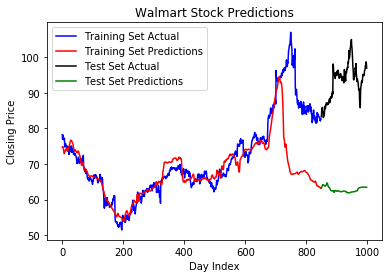

In [50]:
#test function
y_train_preds3, y_test_preds3, train_score3, test_score3 = make_preds('third_model.h5', 
                                                                                         X_train_scaled2, 
                                                                                         X_test_scaled2, 
                                                                                         y_train_scaled2, 
                                                                                         y_test_scaled2, y_scaler2)
make_results_plot(y_train2, y_test2, y_train_preds3, y_test_preds3)

This testing was done with a 180 day set of input data predicting 80 days in the future (about 4 months).  Clearly, this is much worse than before.  It indicates that predicting too far out may not be possible.

### Time Interval Testing

We now take a look at training our model for different sets of input lengths and future test points.  We begin with 20 days input and one day in the future.

In [44]:
#test function
seq_length = 20
fut_point = 1
train_split = 0.85
neurons = [256, 256, 32]
epochs = 300
batch_size = 64
validation_split = 0.15
dropout = 0.2
model_path = 'first_one_day_model.h5'
y_train5, y_test5, y_train_preds5, y_test_preds5, train_score5, test_score5 = fit_generic_LSTM_model(df, 
                                                                                                     seq_length, 
                                                                                                     fut_point, 
                                                                                                     train_split, 
                                                                                                     neurons, 
                                                                                                     dropout, 
                                                                                                     epochs, 
                                                                                                     batch_size,
                                                                                                     validation_split, 
                                                                                                     model_path)

Train on 894 samples, validate on 158 samples
Epoch 1/300
894/894 [==============================] - 5s 5ms/step - loss: 0.0366 - acc: 0.0011 - val_loss: 0.0968 - val_acc: 0.0000e+00
Epoch 2/300
894/894 [==============================] - 1s 1ms/step - loss: 0.0062 - acc: 0.0011 - val_loss: 0.1045 - val_acc: 0.0000e+00
Epoch 3/300
894/894 [==============================] - 1s 1ms/step - loss: 0.0042 - acc: 0.0011 - val_loss: 0.1149 - val_acc: 0.0000e+00
Epoch 4/300
894/894 [==============================] - 1s 1ms/step - loss: 0.0036 - acc: 0.0011 - val_loss: 0.1241 - val_acc: 0.0000e+00
Epoch 5/300
894/894 [==============================] - 1s 1ms/step - loss: 0.0036 - acc: 0.0011 - val_loss: 0.1377 - val_acc: 0.0000e+00
Epoch 6/300
894/894 [==============================] - 1s 1ms/step - loss: 0.0031 - acc: 0.0011 - val_loss: 0.1550 - val_acc: 0.0000e+00
Epoch 7/300
894/894 [==============================] - 1s 1ms/step - loss: 0.0033 - acc: 0.0011 - val_loss: 0.1724 - val_acc: 0.0000

894/894 [==============================] - 1s 1ms/step - loss: 0.0018 - acc: 0.0011 - val_loss: 0.2754 - val_acc: 0.0000e+00
Epoch 120/300
894/894 [==============================] - 1s 2ms/step - loss: 0.0017 - acc: 0.0011 - val_loss: 0.2672 - val_acc: 0.0000e+00
Epoch 121/300
894/894 [==============================] - 1s 2ms/step - loss: 0.0017 - acc: 0.0011 - val_loss: 0.2390 - val_acc: 0.0000e+00
Epoch 122/300
894/894 [==============================] - 1s 2ms/step - loss: 0.0017 - acc: 0.0011 - val_loss: 0.2852 - val_acc: 0.0000e+00
Epoch 123/300
894/894 [==============================] - 1s 2ms/step - loss: 0.0016 - acc: 0.0011 - val_loss: 0.2511 - val_acc: 0.0000e+00
Epoch 124/300
894/894 [==============================] - 1s 2ms/step - loss: 0.0018 - acc: 0.0011 - val_loss: 0.2515 - val_acc: 0.0000e+00
Epoch 125/300
894/894 [==============================] - 1s 2ms/step - loss: 0.0018 - acc: 0.0011 - val_loss: 0.2461 - val_acc: 0.0000e+00
Epoch 126/300
894/894 [==================

894/894 [==============================] - 1s 1ms/step - loss: 0.0018 - acc: 0.0011 - val_loss: 0.1445 - val_acc: 0.0000e+00
Epoch 179/300
894/894 [==============================] - 1s 1ms/step - loss: 0.0015 - acc: 0.0011 - val_loss: 0.1376 - val_acc: 0.0000e+00
Epoch 180/300
894/894 [==============================] - 1s 1ms/step - loss: 0.0017 - acc: 0.0011 - val_loss: 0.1300 - val_acc: 0.0000e+00
Epoch 181/300
894/894 [==============================] - 1s 1ms/step - loss: 0.0017 - acc: 0.0011 - val_loss: 0.1473 - val_acc: 0.0000e+00
Epoch 182/300
894/894 [==============================] - 1s 1ms/step - loss: 0.0015 - acc: 0.0011 - val_loss: 0.1574 - val_acc: 0.0000e+00
Epoch 183/300
894/894 [==============================] - 1s 1ms/step - loss: 0.0016 - acc: 0.0011 - val_loss: 0.1648 - val_acc: 0.0000e+00
Epoch 184/300
894/894 [==============================] - 1s 1ms/step - loss: 0.0015 - acc: 0.0011 - val_loss: 0.1550 - val_acc: 0.0000e+00
Epoch 185/300
894/894 [==================

894/894 [==============================] - 1s 2ms/step - loss: 0.0016 - acc: 0.0011 - val_loss: 0.1067 - val_acc: 0.0000e+00
Epoch 238/300
894/894 [==============================] - 1s 2ms/step - loss: 0.0017 - acc: 0.0011 - val_loss: 0.0969 - val_acc: 0.0000e+00
Epoch 239/300
894/894 [==============================] - 1s 1ms/step - loss: 0.0017 - acc: 0.0011 - val_loss: 0.1140 - val_acc: 0.0000e+00
Epoch 240/300
894/894 [==============================] - 1s 1ms/step - loss: 0.0016 - acc: 0.0011 - val_loss: 0.1126 - val_acc: 0.0000e+00
Epoch 241/300
894/894 [==============================] - 1s 1ms/step - loss: 0.0016 - acc: 0.0011 - val_loss: 0.1298 - val_acc: 0.0000e+00
Epoch 242/300
894/894 [==============================] - 1s 1ms/step - loss: 0.0017 - acc: 0.0011 - val_loss: 0.1058 - val_acc: 0.0000e+00
Epoch 243/300
894/894 [==============================] - 1s 1ms/step - loss: 0.0017 - acc: 0.0011 - val_loss: 0.0717 - val_acc: 0.0000e+00
Epoch 244/300
894/894 [==================

894/894 [==============================] - 1s 2ms/step - loss: 0.0015 - acc: 0.0011 - val_loss: 0.0728 - val_acc: 0.0000e+00
Epoch 297/300
894/894 [==============================] - 1s 1ms/step - loss: 0.0015 - acc: 0.0011 - val_loss: 0.1354 - val_acc: 0.0000e+00
Epoch 298/300
894/894 [==============================] - 1s 1ms/step - loss: 0.0014 - acc: 0.0011 - val_loss: 0.1337 - val_acc: 0.0000e+00
Epoch 299/300
894/894 [==============================] - 1s 1ms/step - loss: 0.0015 - acc: 0.0011 - val_loss: 0.0858 - val_acc: 0.0000e+00
Epoch 300/300
894/894 [==============================] - 1s 1ms/step - loss: 0.0015 - acc: 0.0011 - val_loss: 0.1130 - val_acc: 0.0000e+00
Training Set- Score: 0.018251367610925277, RMSE: 0.13509762252136517
Test Set- Score: 0.12118753662673376, RMSE: 0.3481200031982273


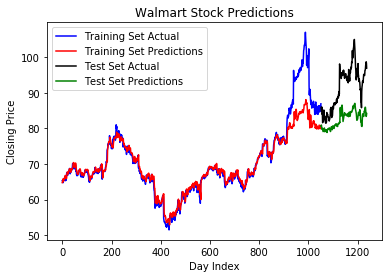

In [45]:
#plot
make_results_plot(y_train5, y_test5, y_train_preds5, y_test_preds5)

We see trends somewhat captured but very off in magnitude.  Now, we try even lengths:  20 days and 20 days.

In [46]:
#test function
seq_length = 20
fut_point = 20
train_split = 0.85
neurons = [256, 256, 32]
epochs = 300
batch_size = 64
validation_split = 0.15
dropout = 0.2
model_path = 'four_week_model.h5'
y_train6, y_test6, y_train_preds6, y_test_preds6, train_score6, test_score6 = fit_generic_LSTM_model(df, 
                                                                                                     seq_length, 
                                                                                                     fut_point, 
                                                                                                     train_split, 
                                                                                                     neurons, 
                                                                                                     dropout, 
                                                                                                     epochs, 
                                                                                                     batch_size,
                                                                                                     validation_split, 
                                                                                                     model_path)

Train on 880 samples, validate on 156 samples
Epoch 1/300
880/880 [==============================] - 5s 6ms/step - loss: 0.0563 - acc: 0.0011 - val_loss: 0.1201 - val_acc: 0.0000e+00
Epoch 2/300
880/880 [==============================] - 1s 1ms/step - loss: 0.0185 - acc: 0.0011 - val_loss: 0.1179 - val_acc: 0.0000e+00
Epoch 3/300
880/880 [==============================] - 1s 1ms/step - loss: 0.0151 - acc: 0.0011 - val_loss: 0.1187 - val_acc: 0.0000e+00
Epoch 4/300
880/880 [==============================] - 1s 1ms/step - loss: 0.0146 - acc: 0.0011 - val_loss: 0.1229 - val_acc: 0.0000e+00
Epoch 5/300
880/880 [==============================] - 1s 1ms/step - loss: 0.0138 - acc: 0.0011 - val_loss: 0.1277 - val_acc: 0.0000e+00
Epoch 6/300
880/880 [==============================] - 1s 1ms/step - loss: 0.0133 - acc: 0.0011 - val_loss: 0.1313 - val_acc: 0.0000e+00
Epoch 7/300
880/880 [==============================] - 1s 1ms/step - loss: 0.0130 - acc: 0.0011 - val_loss: 0.1329 - val_acc: 0.0000

880/880 [==============================] - 1s 2ms/step - loss: 0.0115 - acc: 0.0011 - val_loss: 0.7397 - val_acc: 0.0000e+00
Epoch 120/300
880/880 [==============================] - 1s 1ms/step - loss: 0.0118 - acc: 0.0011 - val_loss: 2.0087 - val_acc: 0.0000e+00
Epoch 121/300
880/880 [==============================] - 1s 2ms/step - loss: 0.0113 - acc: 0.0011 - val_loss: 1.4404 - val_acc: 0.0000e+00
Epoch 122/300
880/880 [==============================] - 1s 2ms/step - loss: 0.0112 - acc: 0.0011 - val_loss: 0.6584 - val_acc: 0.0000e+00
Epoch 123/300
880/880 [==============================] - 1s 1ms/step - loss: 0.0113 - acc: 0.0011 - val_loss: 0.7111 - val_acc: 0.0000e+00
Epoch 124/300
880/880 [==============================] - 1s 1ms/step - loss: 0.0113 - acc: 0.0011 - val_loss: 0.5468 - val_acc: 0.0000e+00
Epoch 125/300
880/880 [==============================] - 1s 1ms/step - loss: 0.0117 - acc: 0.0011 - val_loss: 0.4080 - val_acc: 0.0000e+00
Epoch 126/300
880/880 [==================

880/880 [==============================] - 1s 1ms/step - loss: 0.0093 - acc: 0.0011 - val_loss: 0.2128 - val_acc: 0.0000e+00
Epoch 238/300
880/880 [==============================] - 1s 1ms/step - loss: 0.0098 - acc: 0.0011 - val_loss: 0.2566 - val_acc: 0.0000e+00
Epoch 239/300
880/880 [==============================] - 1s 1ms/step - loss: 0.0096 - acc: 0.0011 - val_loss: 0.1281 - val_acc: 0.0000e+00
Epoch 240/300
880/880 [==============================] - 1s 1ms/step - loss: 0.0097 - acc: 0.0011 - val_loss: 0.1606 - val_acc: 0.0000e+00
Epoch 241/300
880/880 [==============================] - 1s 1ms/step - loss: 0.0105 - acc: 0.0011 - val_loss: 0.2864 - val_acc: 0.0000e+00
Epoch 242/300
880/880 [==============================] - 1s 1ms/step - loss: 0.0106 - acc: 0.0011 - val_loss: 0.3259 - val_acc: 0.0000e+00
Epoch 243/300
880/880 [==============================] - 1s 2ms/step - loss: 0.0095 - acc: 0.0011 - val_loss: 0.1869 - val_acc: 0.0000e+00
Epoch 244/300
880/880 [==================

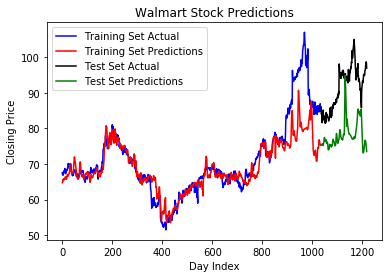

In [47]:
#plot
make_results_plot(y_train6, y_test6, y_train_preds6, y_test_preds6)

Again, the magnitude is off.  We now try one day ahead with one last week (5 days) of data.

In [42]:
#predict one day ahead with last week's data
seq_length = 5
fut_point = 1
train_split = 0.85
neurons = [256, 256, 32]
epochs = 300
batch_size = 64
validation_split = 0.15
dropout = 0.2
model_path = 'one_day_model.h5'
y_train4, y_test4, y_train_preds4, y_test_preds4, train_score4, test_score4 = fit_generic_LSTM_model(df, 
                                                                                                     seq_length, 
                                                                                                     fut_point, 
                                                                                                     train_split, 
                                                                                                     neurons, 
                                                                                                     dropout, 
                                                                                                     epochs, 
                                                                                                     batch_size,
                                                                                                     validation_split, 
                                                                                                     model_path)

Train on 905 samples, validate on 160 samples
Epoch 1/300
905/905 [==============================] - 3s 4ms/step - loss: 0.0426 - acc: 0.0011 - val_loss: 0.1358 - val_acc: 0.0000e+00
Epoch 2/300
905/905 [==============================] - 0s 476us/step - loss: 0.0057 - acc: 0.0011 - val_loss: 0.1239 - val_acc: 0.0000e+00
Epoch 3/300
905/905 [==============================] - 1s 622us/step - loss: 0.0036 - acc: 0.0011 - val_loss: 0.1176 - val_acc: 0.0000e+00
Epoch 4/300
905/905 [==============================] - 0s 516us/step - loss: 0.0031 - acc: 0.0011 - val_loss: 0.1146 - val_acc: 0.0000e+00
Epoch 5/300
905/905 [==============================] - 1s 598us/step - loss: 0.0028 - acc: 0.0011 - val_loss: 0.1163 - val_acc: 0.0000e+00
Epoch 6/300
905/905 [==============================] - 0s 526us/step - loss: 0.0033 - acc: 0.0011 - val_loss: 0.1206 - val_acc: 0.0000e+00
Epoch 7/300
905/905 [==============================] - 1s 718us/step - loss: 0.0029 - acc: 0.0011 - val_loss: 0.1256 - val

905/905 [==============================] - 0s 551us/step - loss: 0.0017 - acc: 0.0011 - val_loss: 0.1440 - val_acc: 0.0000e+00
Epoch 118/300
905/905 [==============================] - 1s 575us/step - loss: 0.0017 - acc: 0.0011 - val_loss: 0.1250 - val_acc: 0.0000e+00
Epoch 119/300
905/905 [==============================] - 1s 573us/step - loss: 0.0016 - acc: 0.0011 - val_loss: 0.1399 - val_acc: 0.0000e+00
Epoch 120/300
905/905 [==============================] - 0s 534us/step - loss: 0.0016 - acc: 0.0011 - val_loss: 0.1327 - val_acc: 0.0000e+00
Epoch 121/300
905/905 [==============================] - 0s 547us/step - loss: 0.0018 - acc: 0.0011 - val_loss: 0.1564 - val_acc: 0.0000e+00
Epoch 122/300
905/905 [==============================] - 0s 547us/step - loss: 0.0017 - acc: 0.0011 - val_loss: 0.1546 - val_acc: 0.0000e+00
Epoch 123/300
905/905 [==============================] - 0s 549us/step - loss: 0.0017 - acc: 0.0011 - val_loss: 0.1390 - val_acc: 0.0000e+00
Epoch 124/300
905/905 [====

905/905 [==============================] - 0s 461us/step - loss: 0.0016 - acc: 0.0011 - val_loss: 0.1545 - val_acc: 0.0000e+00
Epoch 234/300
905/905 [==============================] - 0s 452us/step - loss: 0.0016 - acc: 0.0011 - val_loss: 0.1401 - val_acc: 0.0000e+00
Epoch 235/300
905/905 [==============================] - 0s 474us/step - loss: 0.0016 - acc: 0.0011 - val_loss: 0.1210 - val_acc: 0.0000e+00
Epoch 236/300
905/905 [==============================] - 1s 680us/step - loss: 0.0017 - acc: 0.0011 - val_loss: 0.1137 - val_acc: 0.0000e+00
Epoch 237/300
905/905 [==============================] - 1s 847us/step - loss: 0.0017 - acc: 0.0011 - val_loss: 0.1885 - val_acc: 0.0000e+00
Epoch 238/300
905/905 [==============================] - 1s 587us/step - loss: 0.0016 - acc: 0.0011 - val_loss: 0.1662 - val_acc: 0.0000e+00
Epoch 239/300
905/905 [==============================] - 0s 475us/step - loss: 0.0016 - acc: 0.0011 - val_loss: 0.1501 - val_acc: 0.0000e+00
Epoch 240/300
905/905 [====

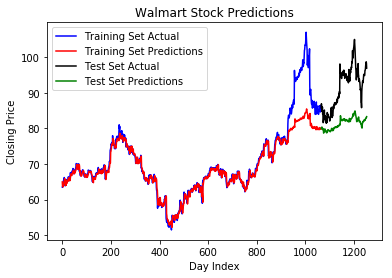

In [43]:
#plot
make_results_plot(y_train4, y_test4, y_train_preds4, y_test_preds4)

It looks like trends might be captured, but magnitude is off again.

### Try different numbers of features

Now, we try to improve the results by training the model hyperparameters.  We begin by checking whether the addition of features improves performance.

We will read in the dataframe again and consider another couple features (volume traded and vwap).

We test compared to the first model.

In [52]:
#load Walmart Stock Data
filepath = os.path.join('..', 'Resources', 'WMT.csv')
new_df = pd.read_csv(filepath)

#drop unnessecary columns
new_df.drop(['unadjustedVolume', 'change', 'changePercent', 'label', 'changeOverTime'], 1, inplace = True)

#set index
new_df.set_index('date', inplace = True)
new_df.head()

,open,high,low,close,volume,vwap
date,,,,,,
2014-01-27,64.7650,64.9747,64.5029,64.7825,9105139,64.7739
2014-01-28,64.8786,65.8746,64.7388,65.2368,6035231,65.3045
2014-01-29,65.7785,65.8484,64.7126,64.7388,8440854,61.0517
2014-01-30,65.1232,65.6037,64.9660,65.3067,6742046,65.2975
2014-01-31,64.5816,65.6911,64.3369,65.2455,10665285,65.3223


We will first run the functions for 30 days sequence and 5 days of future point for the old number of features.

In [53]:
#model for old number of features
seq_length = 30
fut_point = 5
train_split = 0.85
neurons = [256, 256, 32]
epochs = 300
batch_size = 64
validation_split = 0.15
dropout = 0.2
model_path = 'more_features.h5'
y_train3, y_test3, y_train_preds3, y_test_preds3, train_score3, test_score3 = fit_generic_LSTM_model(df, 
                                                                                                     seq_length, 
                                                                                                     fut_point, 
                                                                                                     train_split, 
                                                                                                     neurons, 
                                                                                                     dropout, 
                                                                                                     epochs, 
                                                                                                     batch_size,
                                                                                                     validation_split, 
                                                                                                     model_path)

Train on 884 samples, validate on 156 samples
Epoch 1/300
884/884 [==============================] - 7s 8ms/step - loss: 0.0480 - acc: 0.0011 - val_loss: 0.0932 - val_acc: 0.0000e+00
Epoch 2/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0094 - acc: 0.0011 - val_loss: 0.1219 - val_acc: 0.0000e+00
Epoch 3/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0068 - acc: 0.0011 - val_loss: 0.1185 - val_acc: 0.0000e+00
Epoch 4/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0062 - acc: 0.0011 - val_loss: 0.1181 - val_acc: 0.0000e+00
Epoch 5/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0058 - acc: 0.0011 - val_loss: 0.1282 - val_acc: 0.0000e+00
Epoch 6/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0054 - acc: 0.0011 - val_loss: 0.1383 - val_acc: 0.0000e+00
Epoch 7/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0051 - acc: 0.0011 - val_loss: 0.1467 - val_acc: 0.0000

884/884 [==============================] - 2s 2ms/step - loss: 0.0035 - acc: 0.0011 - val_loss: 0.1146 - val_acc: 0.0064
Epoch 121/300
884/884 [==============================] - 3s 3ms/step - loss: 0.0038 - acc: 0.0011 - val_loss: 0.0364 - val_acc: 0.0064
Epoch 122/300
884/884 [==============================] - 3s 3ms/step - loss: 0.0039 - acc: 0.0011 - val_loss: 0.1258 - val_acc: 0.0064
Epoch 123/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0038 - acc: 0.0011 - val_loss: 0.1360 - val_acc: 0.0064
Epoch 124/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0038 - acc: 0.0011 - val_loss: 0.1143 - val_acc: 0.0064
Epoch 125/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0037 - acc: 0.0011 - val_loss: 0.0398 - val_acc: 0.0064
Epoch 126/300
884/884 [==============================] - 2s 3ms/step - loss: 0.0037 - acc: 0.0011 - val_loss: 0.0347 - val_acc: 0.0064
Epoch 127/300
884/884 [==============================] - 3s 3ms/step 

Epoch 241/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0031 - acc: 0.0011 - val_loss: 0.0338 - val_acc: 0.0064
Epoch 242/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0032 - acc: 0.0011 - val_loss: 0.0260 - val_acc: 0.0064
Epoch 243/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0033 - acc: 0.0011 - val_loss: 0.0445 - val_acc: 0.0000e+00
Epoch 244/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0032 - acc: 0.0011 - val_loss: 0.0255 - val_acc: 0.0064
Epoch 245/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0030 - acc: 0.0011 - val_loss: 0.0386 - val_acc: 0.0064
Epoch 246/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0036 - acc: 0.0011 - val_loss: 0.0371 - val_acc: 0.0064
Epoch 247/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0033 - acc: 0.0011 - val_loss: 0.0348 - val_acc: 0.0064
Epoch 248/300
884/884 [============================

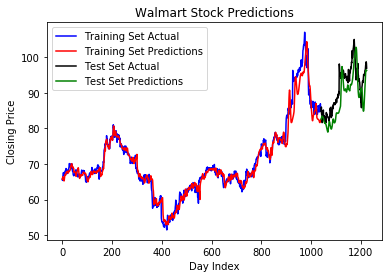

In [54]:
#plot
make_results_plot(y_train3, y_test3, y_train_preds3, y_test_preds3)

In [59]:
#model for new number of features
seq_length = 30
fut_point = 5
train_split = 0.85
neurons = [256, 256, 32]
epochs = 300
batch_size = 64
validation_split = 0.15
dropout = 0.2
model_path = 'more_features_real_long.h5'
y_train3, y_test3, y_train_preds3, y_test_preds3, train_score3, test_score3 = fit_generic_LSTM_model(new_df, 
                                                                                                     seq_length, 
                                                                                                     fut_point, 
                                                                                                     train_split, 
                                                                                                     neurons, 
                                                                                                     dropout, 
                                                                                                     epochs, 
                                                                                                     batch_size,
                                                                                                     validation_split, 
                                                                                                     model_path)

Train on 884 samples, validate on 156 samples
Epoch 1/300
884/884 [==============================] - 8s 9ms/step - loss: 0.0548 - acc: 0.0011 - val_loss: 0.1058 - val_acc: 0.0000e+00
Epoch 2/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0092 - acc: 0.0011 - val_loss: 0.1263 - val_acc: 0.0000e+00
Epoch 3/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0066 - acc: 0.0011 - val_loss: 0.1511 - val_acc: 0.0000e+00
Epoch 4/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0062 - acc: 0.0011 - val_loss: 0.1673 - val_acc: 0.0000e+00
Epoch 5/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0059 - acc: 0.0011 - val_loss: 0.1731 - val_acc: 0.0000e+00
Epoch 6/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0054 - acc: 0.0011 - val_loss: 0.1909 - val_acc: 0.0000e+00
Epoch 7/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0052 - acc: 0.0011 - val_loss: 0.1707 - val_acc: 0.0000

884/884 [==============================] - 2s 2ms/step - loss: 0.0038 - acc: 0.0011 - val_loss: 0.1155 - val_acc: 0.0000e+00
Epoch 120/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0041 - acc: 0.0011 - val_loss: 0.1431 - val_acc: 0.0000e+00
Epoch 121/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0043 - acc: 0.0011 - val_loss: 0.1019 - val_acc: 0.0000e+00
Epoch 122/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0040 - acc: 0.0011 - val_loss: 0.1450 - val_acc: 0.0000e+00
Epoch 123/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0038 - acc: 0.0011 - val_loss: 0.0762 - val_acc: 0.0000e+00
Epoch 124/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0038 - acc: 0.0011 - val_loss: 0.0607 - val_acc: 0.0064
Epoch 125/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0038 - acc: 0.0011 - val_loss: 0.1088 - val_acc: 0.0000e+00
Epoch 126/300
884/884 [======================

Epoch 179/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0036 - acc: 0.0011 - val_loss: 0.0548 - val_acc: 0.0064
Epoch 180/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0033 - acc: 0.0011 - val_loss: 0.0374 - val_acc: 0.0064
Epoch 181/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0033 - acc: 0.0011 - val_loss: 0.0649 - val_acc: 0.0064
Epoch 182/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0031 - acc: 0.0011 - val_loss: 0.0442 - val_acc: 0.0064
Epoch 183/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0034 - acc: 0.0011 - val_loss: 0.0468 - val_acc: 0.0064
Epoch 184/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0032 - acc: 0.0011 - val_loss: 0.0424 - val_acc: 0.0064
Epoch 185/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0033 - acc: 0.0011 - val_loss: 0.0391 - val_acc: 0.0064
Epoch 186/300
884/884 [==============================] 

Epoch 299/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0025 - acc: 0.0011 - val_loss: 0.0915 - val_acc: 0.0000e+00
Epoch 300/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0022 - acc: 0.0011 - val_loss: 0.0453 - val_acc: 0.0064
Training Set- Score: 0.008340317677133358, RMSE: 0.09132533973182556
Test Set- Score: 0.04561135691145192, RMSE: 0.2135681551904495


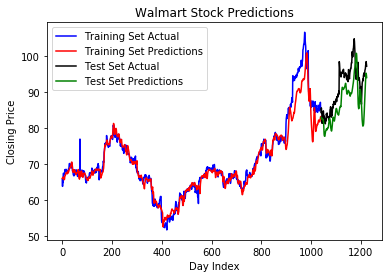

In [60]:
#plot
make_results_plot(y_train3, y_test3, y_train_preds3, y_test_preds3)

In [57]:
#test with 5 days sequence 1 day future point
seq_length = 5
fut_point = 1
train_split = 0.85
neurons = [256, 256, 32]
epochs = 300
batch_size = 64
validation_split = 0.15
dropout = 0.2
model_path = 'more_features_real.h5'
y_train3, y_test3, y_train_preds3, y_test_preds3, train_score3, test_score3 = fit_generic_LSTM_model(new_df, 
                                                                                                     seq_length, 
                                                                                                     fut_point, 
                                                                                                     train_split, 
                                                                                                     neurons, 
                                                                                                     dropout, 
                                                                                                     epochs, 
                                                                                                     batch_size,
                                                                                                     validation_split, 
                                                                                                     model_path)

Train on 905 samples, validate on 160 samples
Epoch 1/300
905/905 [==============================] - 6s 7ms/step - loss: 0.0509 - acc: 0.0011 - val_loss: 0.1171 - val_acc: 0.0000e+00
Epoch 2/300
905/905 [==============================] - 0s 541us/step - loss: 0.0060 - acc: 0.0011 - val_loss: 0.1151 - val_acc: 0.0000e+00
Epoch 3/300
905/905 [==============================] - 1s 574us/step - loss: 0.0031 - acc: 0.0011 - val_loss: 0.1254 - val_acc: 0.0000e+00
Epoch 4/300
905/905 [==============================] - 1s 553us/step - loss: 0.0032 - acc: 0.0011 - val_loss: 0.1274 - val_acc: 0.0000e+00
Epoch 5/300
905/905 [==============================] - 1s 578us/step - loss: 0.0032 - acc: 0.0011 - val_loss: 0.1339 - val_acc: 0.0000e+00
Epoch 6/300
905/905 [==============================] - 1s 554us/step - loss: 0.0029 - acc: 0.0011 - val_loss: 0.1376 - val_acc: 0.0000e+00
Epoch 7/300
905/905 [==============================] - 1s 581us/step - loss: 0.0029 - acc: 0.0011 - val_loss: 0.1406 - val

905/905 [==============================] - 1s 629us/step - loss: 0.0020 - acc: 0.0011 - val_loss: 0.1621 - val_acc: 0.0000e+00
Epoch 118/300
905/905 [==============================] - 1s 583us/step - loss: 0.0020 - acc: 0.0011 - val_loss: 0.1225 - val_acc: 0.0000e+00
Epoch 119/300
905/905 [==============================] - 1s 594us/step - loss: 0.0017 - acc: 0.0011 - val_loss: 0.0879 - val_acc: 0.0000e+00
Epoch 120/300
905/905 [==============================] - 1s 584us/step - loss: 0.0018 - acc: 0.0011 - val_loss: 0.1197 - val_acc: 0.0000e+00
Epoch 121/300
905/905 [==============================] - 1s 595us/step - loss: 0.0019 - acc: 0.0011 - val_loss: 0.0508 - val_acc: 0.0000e+00
Epoch 122/300
905/905 [==============================] - 1s 602us/step - loss: 0.0018 - acc: 0.0011 - val_loss: 0.1184 - val_acc: 0.0000e+00
Epoch 123/300
905/905 [==============================] - 1s 574us/step - loss: 0.0018 - acc: 0.0011 - val_loss: 0.1145 - val_acc: 0.0000e+00
Epoch 124/300
905/905 [====

905/905 [==============================] - 0s 548us/step - loss: 0.0017 - acc: 0.0011 - val_loss: 0.1260 - val_acc: 0.0000e+00
Epoch 234/300
905/905 [==============================] - 0s 547us/step - loss: 0.0017 - acc: 0.0011 - val_loss: 0.1448 - val_acc: 0.0000e+00
Epoch 235/300
905/905 [==============================] - 0s 538us/step - loss: 0.0017 - acc: 0.0011 - val_loss: 0.1373 - val_acc: 0.0000e+00
Epoch 236/300
905/905 [==============================] - 0s 537us/step - loss: 0.0018 - acc: 0.0011 - val_loss: 0.1491 - val_acc: 0.0000e+00
Epoch 237/300
905/905 [==============================] - 0s 552us/step - loss: 0.0017 - acc: 0.0011 - val_loss: 0.1414 - val_acc: 0.0000e+00
Epoch 238/300
905/905 [==============================] - 0s 540us/step - loss: 0.0016 - acc: 0.0011 - val_loss: 0.1378 - val_acc: 0.0000e+00
Epoch 239/300
905/905 [==============================] - 0s 549us/step - loss: 0.0016 - acc: 0.0011 - val_loss: 0.1252 - val_acc: 0.0000e+00
Epoch 240/300
905/905 [====

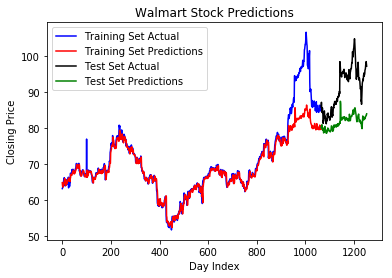

In [58]:
#plot
make_results_plot(y_train3, y_test3, y_train_preds3, y_test_preds3)

We don't see any improved performance, so it seems justifiable to include the simpler set of data.

### Hyperparameter Tuning
Now, we attempt to tune hyperparameters of the model.

First, we will look at number of neurons.  For all of these first trials, we will use a sequence length of thirty days
and a future point of five points as that gave us our seeming best performance before.

We begin by training the number of neurons.  As with any hyperparameter training, the process is to run the training and use the training set score to choose the best performance.

In [22]:
#look at number of neurons
#use training score as metric (should really only score on test set when done.)
#set up parameters
seq_length = 30
fut_point = 5
train_split = 0.85
#neurons = [256, 256, 32]
epochs = 300
batch_size = 64
validation_split = 0.15
dropout = 0.2
model_path = 'dummy_path.h5'

#set up variances of neuron size
neuron_lengths = [[256, 256, 32], [256, 256, 16], [128, 128, 32], [128, 128, 16], [64, 64, 32], [64, 64, 16]]

#create lists to store results
neurons = []
train_scores = []

#iterate
for neuron_length in neuron_lengths:
    neurons.append(f"{neuron_length}")
    
    train, test, train_preds, test_preds, train_score, test_score = fit_generic_LSTM_model(df, seq_length, 
                                                                                                     fut_point, 
                                                                                                     train_split, 
                                                                                                     neuron_length, 
                                                                                                     dropout, 
                                                                                                     epochs, 
                                                                                                     batch_size,
                                                                                                     validation_split, 
                                                                                                     model_path)
    
    train_scores.append(train_score)
    
#create dataframe
results = pd.DataFrame({'Neuron Lengths': neurons, 'Train Scores': train_scores})

results.plot.bar(x = 'Neuron Lengths', y = 'Train Scores')

Train on 884 samples, validate on 156 samples
Epoch 1/300
884/884 [==============================] - 3s 4ms/step - loss: 0.0405 - acc: 0.0000e+00 - val_loss: 0.1296 - val_acc: 0.0000e+00
Epoch 2/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0068 - acc: 0.0011 - val_loss: 0.1641 - val_acc: 0.0000e+00
Epoch 3/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0058 - acc: 0.0011 - val_loss: 0.1728 - val_acc: 0.0000e+00
Epoch 4/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0056 - acc: 0.0011 - val_loss: 0.1824 - val_acc: 0.0000e+00
Epoch 5/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0056 - acc: 0.0011 - val_loss: 0.1828 - val_acc: 0.0000e+00
Epoch 6/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0054 - acc: 0.0011 - val_loss: 0.1783 - val_acc: 0.0000e+00
Epoch 7/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0053 - acc: 0.0011 - val_loss: 0.1677 - val_acc: 0.

884/884 [==============================] - 2s 2ms/step - loss: 0.0040 - acc: 0.0011 - val_loss: 0.2896 - val_acc: 0.0000e+00
Epoch 61/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0040 - acc: 0.0011 - val_loss: 0.2654 - val_acc: 0.0000e+00
Epoch 62/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0041 - acc: 0.0011 - val_loss: 0.2540 - val_acc: 0.0000e+00
Epoch 63/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0043 - acc: 0.0011 - val_loss: 0.2687 - val_acc: 0.0000e+00
Epoch 64/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0043 - acc: 0.0011 - val_loss: 0.2304 - val_acc: 0.0000e+00
Epoch 65/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0042 - acc: 0.0011 - val_loss: 0.2343 - val_acc: 0.0000e+00
Epoch 66/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0040 - acc: 0.0011 - val_loss: 0.1899 - val_acc: 0.0000e+00
Epoch 67/300
884/884 [=========================

884/884 [==============================] - 2s 2ms/step - loss: 0.0036 - acc: 0.0011 - val_loss: 0.0653 - val_acc: 0.0064
Epoch 181/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0034 - acc: 0.0011 - val_loss: 0.0791 - val_acc: 0.0064
Epoch 182/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0031 - acc: 0.0011 - val_loss: 0.0700 - val_acc: 0.0064
Epoch 183/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0032 - acc: 0.0011 - val_loss: 0.0587 - val_acc: 0.0064
Epoch 184/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0034 - acc: 0.0011 - val_loss: 0.0571 - val_acc: 0.0064
Epoch 185/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0033 - acc: 0.0011 - val_loss: 0.0521 - val_acc: 0.0064
Epoch 186/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0033 - acc: 0.0011 - val_loss: 0.0602 - val_acc: 0.0064
Epoch 187/300
884/884 [==============================] - 2s 2ms/step 

884/884 [==============================] - 2s 2ms/step - loss: 0.0026 - acc: 0.0011 - val_loss: 0.0382 - val_acc: 0.0064
Epoch 300/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0026 - acc: 0.0011 - val_loss: 0.0627 - val_acc: 0.0000e+00
Training Set- Score: 0.011277323450821523, RMSE: 0.10619474304701491
Test Set- Score: 0.06465379343084666, RMSE: 0.25427110223312177
Train on 884 samples, validate on 156 samples
Epoch 1/300
884/884 [==============================] - 3s 4ms/step - loss: 0.0320 - acc: 0.0011 - val_loss: 0.1392 - val_acc: 0.0000e+00
Epoch 2/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0085 - acc: 0.0011 - val_loss: 0.1570 - val_acc: 0.0000e+00
Epoch 3/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0064 - acc: 0.0011 - val_loss: 0.1729 - val_acc: 0.0000e+00
Epoch 4/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0054 - acc: 0.0011 - val_loss: 0.1781 - val_acc: 0.0000e+00
Epoch 5/300
8

Epoch 117/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0038 - acc: 0.0011 - val_loss: 0.0544 - val_acc: 0.0064
Epoch 118/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0038 - acc: 0.0011 - val_loss: 0.1179 - val_acc: 0.0064
Epoch 119/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0035 - acc: 0.0011 - val_loss: 0.1621 - val_acc: 0.0000e+00
Epoch 120/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0037 - acc: 0.0011 - val_loss: 0.2181 - val_acc: 0.0000e+00
Epoch 121/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0039 - acc: 0.0011 - val_loss: 0.0944 - val_acc: 0.0000e+00
Epoch 122/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0036 - acc: 0.0011 - val_loss: 0.0484 - val_acc: 0.0000e+00
Epoch 123/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0037 - acc: 0.0011 - val_loss: 0.0398 - val_acc: 0.0000e+00
Epoch 124/300
884/884 [============

884/884 [==============================] - 2s 3ms/step - loss: 0.0032 - acc: 0.0011 - val_loss: 0.0322 - val_acc: 0.0064
Epoch 238/300
884/884 [==============================] - 2s 3ms/step - loss: 0.0030 - acc: 0.0011 - val_loss: 0.0458 - val_acc: 0.0064
Epoch 239/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0031 - acc: 0.0011 - val_loss: 0.1590 - val_acc: 0.0000e+00
Epoch 240/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0032 - acc: 0.0011 - val_loss: 0.0621 - val_acc: 0.0064
Epoch 241/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0031 - acc: 0.0011 - val_loss: 0.0492 - val_acc: 0.0064
Epoch 242/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0031 - acc: 0.0011 - val_loss: 0.0411 - val_acc: 0.0064
Epoch 243/300
884/884 [==============================] - 2s 2ms/step - loss: 0.0034 - acc: 0.0011 - val_loss: 0.0526 - val_acc: 0.0064
Epoch 244/300
884/884 [==============================] - 2s 2ms/s

884/884 [==============================] - 1s 998us/step - loss: 0.0046 - acc: 0.0011 - val_loss: 0.1462 - val_acc: 0.0000e+00
Epoch 56/300
884/884 [==============================] - 1s 991us/step - loss: 0.0043 - acc: 0.0011 - val_loss: 0.1606 - val_acc: 0.0000e+00
Epoch 57/300
884/884 [==============================] - 1s 995us/step - loss: 0.0044 - acc: 0.0011 - val_loss: 0.1570 - val_acc: 0.0000e+00
Epoch 58/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0044 - acc: 0.0011 - val_loss: 0.1433 - val_acc: 0.0000e+00
Epoch 59/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0044 - acc: 0.0011 - val_loss: 0.1461 - val_acc: 0.0000e+00
Epoch 60/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0045 - acc: 0.0011 - val_loss: 0.1323 - val_acc: 0.0000e+00
Epoch 61/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0044 - acc: 0.0011 - val_loss: 0.1212 - val_acc: 0.0000e+00
Epoch 62/300
884/884 [===================

884/884 [==============================] - 1s 1ms/step - loss: 0.0037 - acc: 0.0011 - val_loss: 0.0484 - val_acc: 0.0064
Epoch 175/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0037 - acc: 0.0011 - val_loss: 0.0608 - val_acc: 0.0064
Epoch 176/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0036 - acc: 0.0011 - val_loss: 0.0647 - val_acc: 0.0064
Epoch 177/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0037 - acc: 0.0011 - val_loss: 0.0598 - val_acc: 0.0064
Epoch 178/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0035 - acc: 0.0011 - val_loss: 0.0295 - val_acc: 0.0064
Epoch 179/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0035 - acc: 0.0011 - val_loss: 0.0454 - val_acc: 0.0064
Epoch 180/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0034 - acc: 0.0011 - val_loss: 0.0882 - val_acc: 0.0064
Epoch 181/300
884/884 [==============================] - 1s 1ms/step 

884/884 [==============================] - 1s 1ms/step - loss: 0.0031 - acc: 0.0011 - val_loss: 0.1032 - val_acc: 0.0064
Epoch 295/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0030 - acc: 0.0011 - val_loss: 0.1052 - val_acc: 0.0064
Epoch 296/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0032 - acc: 0.0011 - val_loss: 0.1309 - val_acc: 0.0064
Epoch 297/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0032 - acc: 0.0011 - val_loss: 0.0622 - val_acc: 0.0064
Epoch 298/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0031 - acc: 0.0011 - val_loss: 0.0691 - val_acc: 0.0064
Epoch 299/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0032 - acc: 0.0011 - val_loss: 0.0687 - val_acc: 0.0064
Epoch 300/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0032 - acc: 0.0011 - val_loss: 0.0513 - val_acc: 0.0064
Training Set- Score: 0.010154810512008575, RMSE: 0.10077107974021403


884/884 [==============================] - 1s 1ms/step - loss: 0.0041 - acc: 0.0011 - val_loss: 0.2096 - val_acc: 0.0000e+00
Epoch 112/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0040 - acc: 0.0011 - val_loss: 0.2255 - val_acc: 0.0000e+00
Epoch 113/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0039 - acc: 0.0011 - val_loss: 0.1708 - val_acc: 0.0000e+00
Epoch 114/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0041 - acc: 0.0011 - val_loss: 0.2041 - val_acc: 0.0000e+00
Epoch 115/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0041 - acc: 0.0011 - val_loss: 0.1812 - val_acc: 0.0000e+00
Epoch 116/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0038 - acc: 0.0011 - val_loss: 0.2097 - val_acc: 0.0000e+00
Epoch 117/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0041 - acc: 0.0011 - val_loss: 0.1677 - val_acc: 0.0000e+00
Epoch 118/300
884/884 [==================

884/884 [==============================] - 1s 1ms/step - loss: 0.0038 - acc: 0.0011 - val_loss: 0.0561 - val_acc: 0.0000e+00
Epoch 171/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0037 - acc: 0.0011 - val_loss: 0.0499 - val_acc: 0.0000e+00
Epoch 172/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0038 - acc: 0.0011 - val_loss: 0.0657 - val_acc: 0.0000e+00
Epoch 173/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0037 - acc: 0.0011 - val_loss: 0.0757 - val_acc: 0.0000e+00
Epoch 174/300
884/884 [==============================] - 1s 991us/step - loss: 0.0037 - acc: 0.0011 - val_loss: 0.0644 - val_acc: 0.0000e+00
Epoch 175/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0037 - acc: 0.0011 - val_loss: 0.0717 - val_acc: 0.0000e+00
Epoch 176/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0037 - acc: 0.0011 - val_loss: 0.0362 - val_acc: 0.0064
Epoch 177/300
884/884 [====================

Epoch 291/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0032 - acc: 0.0011 - val_loss: 0.0277 - val_acc: 0.0064
Epoch 292/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0032 - acc: 0.0011 - val_loss: 0.0390 - val_acc: 0.0064
Epoch 293/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0030 - acc: 0.0011 - val_loss: 0.0335 - val_acc: 0.0064
Epoch 294/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0031 - acc: 0.0011 - val_loss: 0.0275 - val_acc: 0.0064
Epoch 295/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0031 - acc: 0.0011 - val_loss: 0.0398 - val_acc: 0.0064
Epoch 296/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0032 - acc: 0.0011 - val_loss: 0.1350 - val_acc: 0.0064
Epoch 297/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0032 - acc: 0.0011 - val_loss: 0.0305 - val_acc: 0.0064
Epoch 298/300
884/884 [==============================] 

884/884 [==============================] - 1s 782us/step - loss: 0.0039 - acc: 0.0011 - val_loss: 0.0842 - val_acc: 0.0000e+00
Epoch 107/300
884/884 [==============================] - 1s 777us/step - loss: 0.0043 - acc: 0.0011 - val_loss: 0.0660 - val_acc: 0.0000e+00
Epoch 108/300
884/884 [==============================] - 1s 734us/step - loss: 0.0041 - acc: 0.0011 - val_loss: 0.0930 - val_acc: 0.0000e+00
Epoch 109/300
884/884 [==============================] - 1s 792us/step - loss: 0.0042 - acc: 0.0011 - val_loss: 0.0800 - val_acc: 0.0000e+00
Epoch 110/300
884/884 [==============================] - 1s 777us/step - loss: 0.0043 - acc: 0.0011 - val_loss: 0.0794 - val_acc: 0.0000e+00
Epoch 111/300
884/884 [==============================] - 1s 783us/step - loss: 0.0040 - acc: 0.0011 - val_loss: 0.0896 - val_acc: 0.0000e+00
Epoch 112/300
884/884 [==============================] - 1s 779us/step - loss: 0.0040 - acc: 0.0011 - val_loss: 0.0827 - val_acc: 0.0000e+00
Epoch 113/300
884/884 [====

884/884 [==============================] - 1s 768us/step - loss: 0.0038 - acc: 0.0011 - val_loss: 0.0361 - val_acc: 0.0064
Epoch 223/300
884/884 [==============================] - 1s 778us/step - loss: 0.0036 - acc: 0.0011 - val_loss: 0.0364 - val_acc: 0.0064
Epoch 224/300
884/884 [==============================] - 1s 787us/step - loss: 0.0038 - acc: 0.0011 - val_loss: 0.0460 - val_acc: 0.0064
Epoch 225/300
884/884 [==============================] - 1s 782us/step - loss: 0.0038 - acc: 0.0011 - val_loss: 0.0401 - val_acc: 0.0064
Epoch 226/300
884/884 [==============================] - 1s 803us/step - loss: 0.0037 - acc: 0.0011 - val_loss: 0.0387 - val_acc: 0.0064
Epoch 227/300
884/884 [==============================] - 1s 897us/step - loss: 0.0039 - acc: 0.0011 - val_loss: 0.0455 - val_acc: 0.0064
Epoch 228/300
884/884 [==============================] - 1s 898us/step - loss: 0.0040 - acc: 0.0011 - val_loss: 0.0420 - val_acc: 0.0064
Epoch 229/300
884/884 [==============================] 

884/884 [==============================] - 1s 837us/step - loss: 0.0054 - acc: 0.0011 - val_loss: 0.0537 - val_acc: 0.0000e+00
Epoch 39/300
884/884 [==============================] - 1s 881us/step - loss: 0.0048 - acc: 0.0011 - val_loss: 0.0537 - val_acc: 0.0000e+00
Epoch 40/300
884/884 [==============================] - 1s 845us/step - loss: 0.0052 - acc: 0.0011 - val_loss: 0.0530 - val_acc: 0.0000e+00
Epoch 41/300
884/884 [==============================] - 1s 842us/step - loss: 0.0053 - acc: 0.0011 - val_loss: 0.0477 - val_acc: 0.0000e+00
Epoch 42/300
884/884 [==============================] - 1s 853us/step - loss: 0.0050 - acc: 0.0011 - val_loss: 0.0469 - val_acc: 0.0000e+00
Epoch 43/300
884/884 [==============================] - 1s 866us/step - loss: 0.0052 - acc: 0.0011 - val_loss: 0.0506 - val_acc: 0.0000e+00
Epoch 44/300
884/884 [==============================] - 1s 864us/step - loss: 0.0054 - acc: 0.0011 - val_loss: 0.0512 - val_acc: 0.0000e+00
Epoch 45/300
884/884 [===========

884/884 [==============================] - 1s 771us/step - loss: 0.0041 - acc: 0.0011 - val_loss: 0.1273 - val_acc: 0.0000e+00
Epoch 155/300
884/884 [==============================] - 1s 778us/step - loss: 0.0040 - acc: 0.0011 - val_loss: 0.1650 - val_acc: 0.0000e+00
Epoch 156/300
884/884 [==============================] - 1s 747us/step - loss: 0.0044 - acc: 0.0011 - val_loss: 0.1547 - val_acc: 0.0000e+00
Epoch 157/300
884/884 [==============================] - 1s 770us/step - loss: 0.0042 - acc: 0.0011 - val_loss: 0.1463 - val_acc: 0.0000e+00
Epoch 158/300
884/884 [==============================] - 1s 779us/step - loss: 0.0040 - acc: 0.0011 - val_loss: 0.1433 - val_acc: 0.0000e+00
Epoch 159/300
884/884 [==============================] - 1s 778us/step - loss: 0.0042 - acc: 0.0011 - val_loss: 0.1558 - val_acc: 0.0000e+00
Epoch 160/300
884/884 [==============================] - 1s 786us/step - loss: 0.0041 - acc: 0.0011 - val_loss: 0.1548 - val_acc: 0.0000e+00
Epoch 161/300
884/884 [====

884/884 [==============================] - 1s 870us/step - loss: 0.0038 - acc: 0.0011 - val_loss: 0.0655 - val_acc: 0.0000e+00
Epoch 271/300
884/884 [==============================] - 1s 838us/step - loss: 0.0038 - acc: 0.0011 - val_loss: 0.0429 - val_acc: 0.0064
Epoch 272/300
884/884 [==============================] - 1s 838us/step - loss: 0.0036 - acc: 0.0011 - val_loss: 0.0583 - val_acc: 0.0000e+00
Epoch 273/300
884/884 [==============================] - 1s 782us/step - loss: 0.0038 - acc: 0.0011 - val_loss: 0.0743 - val_acc: 0.0000e+00
Epoch 274/300
884/884 [==============================] - 1s 806us/step - loss: 0.0037 - acc: 0.0011 - val_loss: 0.0650 - val_acc: 0.0000e+00
Epoch 275/300
884/884 [==============================] - 1s 779us/step - loss: 0.0038 - acc: 0.0011 - val_loss: 0.0480 - val_acc: 0.0000e+00
Epoch 276/300
884/884 [==============================] - 1s 777us/step - loss: 0.0038 - acc: 0.0011 - val_loss: 0.0484 - val_acc: 0.0064
Epoch 277/300
884/884 [============

TypeError: Empty 'DataFrame': no numeric data to plot

In [23]:
results

,Neuron Lengths,Train Scores
0,"[256, 256, 32]","[0.011277323450821523, 0.0009615384615384616]"
1,"[256, 256, 16]","[0.007928202011121007, 0.0019230769230769232]"
2,"[128, 128, 32]","[0.010154810512008575, 0.0019230769230769232]"
3,"[128, 128, 16]","[0.0062098498303944675, 0.0019230769230769232]"
4,"[64, 64, 32]","[0.00840558975827522, 0.0019230769230769232]"
5,"[64, 64, 16]","[0.008468011232952658, 0.0019230769230769232]"


The result of interest is the first number in the train score column.  Now, we try to train 128 neurons in each of the first two LSTM layers and 16 in the final Dense layer.  Now we train it and visualize it.

In [24]:
#train model for 128, 128, 16 and visualize
seq_length = 30
fut_point = 5
train_split = 0.85
neurons = [128, 128, 16]
epochs = 300
batch_size = 64
validation_split = 0.15
dropout = 0.2
model_path = 'low_neurons.h5'
y_train3, y_test3, y_train_preds3, y_test_preds3, train_score3, test_score3 = fit_generic_LSTM_model(df, 
                                                                                                     seq_length, 
                                                                                                     fut_point, 
                                                                                                     train_split, 
                                                                                                     neurons, 
                                                                                                     dropout, 
                                                                                                     epochs, 
                                                                                                     batch_size,
                                                                                                     validation_split, 
                                                                                                     model_path)

Train on 884 samples, validate on 156 samples
Epoch 1/300
884/884 [==============================] - 4s 5ms/step - loss: 0.0746 - acc: 0.0000e+00 - val_loss: 0.1045 - val_acc: 0.0000e+00
Epoch 2/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0139 - acc: 0.0011 - val_loss: 0.1161 - val_acc: 0.0000e+00
Epoch 3/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0098 - acc: 0.0011 - val_loss: 0.1202 - val_acc: 0.0000e+00
Epoch 4/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0073 - acc: 0.0011 - val_loss: 0.1175 - val_acc: 0.0000e+00
Epoch 5/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0068 - acc: 0.0011 - val_loss: 0.1180 - val_acc: 0.0000e+00
Epoch 6/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0061 - acc: 0.0011 - val_loss: 0.1204 - val_acc: 0.0000e+00
Epoch 7/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0062 - acc: 0.0011 - val_loss: 0.1147 - val_acc: 0.

884/884 [==============================] - 1s 1ms/step - loss: 0.0044 - acc: 0.0011 - val_loss: 0.2329 - val_acc: 0.0000e+00
Epoch 61/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0043 - acc: 0.0011 - val_loss: 0.2326 - val_acc: 0.0000e+00
Epoch 62/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0042 - acc: 0.0011 - val_loss: 0.2682 - val_acc: 0.0000e+00
Epoch 63/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0044 - acc: 0.0011 - val_loss: 0.2977 - val_acc: 0.0000e+00
Epoch 64/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0044 - acc: 0.0011 - val_loss: 0.2507 - val_acc: 0.0000e+00
Epoch 65/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0044 - acc: 0.0011 - val_loss: 0.2297 - val_acc: 0.0000e+00
Epoch 66/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0044 - acc: 0.0011 - val_loss: 0.2235 - val_acc: 0.0000e+00
Epoch 67/300
884/884 [=========================

884/884 [==============================] - 1s 1ms/step - loss: 0.0034 - acc: 0.0011 - val_loss: 0.1702 - val_acc: 0.0064
Epoch 180/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0034 - acc: 0.0011 - val_loss: 0.1670 - val_acc: 0.0064
Epoch 181/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0037 - acc: 0.0011 - val_loss: 0.0623 - val_acc: 0.0064
Epoch 182/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0035 - acc: 0.0011 - val_loss: 0.1169 - val_acc: 0.0064
Epoch 183/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0035 - acc: 0.0011 - val_loss: 0.1051 - val_acc: 0.0064
Epoch 184/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0036 - acc: 0.0011 - val_loss: 0.1035 - val_acc: 0.0064
Epoch 185/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0035 - acc: 0.0011 - val_loss: 0.0891 - val_acc: 0.0064
Epoch 186/300
884/884 [==============================] - 1s 1ms/step 

Epoch 300/300
884/884 [==============================] - 1s 1ms/step - loss: 0.0031 - acc: 0.0011 - val_loss: 0.0460 - val_acc: 0.0064
Training Set- Score: 0.009353225429255803, RMSE: 0.09671207488858774
Test Set- Score: 0.027158301809559696, RMSE: 0.1647977603293191


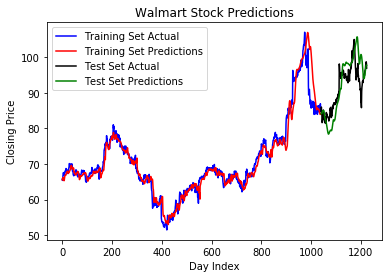

In [27]:
#plot
make_results_plot(y_train3, y_test3, y_train_preds3, y_test_preds3)

It seems there is a bit of randomness in the training scores in different training runs (likely due to different starting weights and which variables are dropped in dropout layers during fitting).  They seem to score about the same.  As a simpler network seems to work than our original model, we will use it (128, 128, 16).

#### Number of Epochs

We will look at how the number of epochs affects our error.  The inbuilt fit function in Keras has a way of doing this.  We create a function to do this.


In [28]:
def see_history(df, seq_length, fut_point, train_split, neurons, dropout, epochs, batch_size, 
                           validation_split, model_path):
    
    #get train/test split
    X_train, X_test, y_train, y_test = train_test_splitter(df, seq_length, fut_point, train_split)
    
    #get number of features
    features = X_train.shape[2]
    
    #get scalers and normalized data
    X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, X_scaler, y_scaler = create_scalers_and_normalize(
        X_train, X_test, y_train, y_test)
    
    #create model
    model = create_generic_LSTM_model(neurons, dropout, seq_length, features)
    
    #fit model
    history = model.fit(X_train_scaled, y_train_scaled, epochs = epochs, 
              batch_size = batch_size, validation_split = validation_split, verbose = 1)
    
    #save model
    model.save(model_path)
    
    return history

In [29]:
#do so
seq_length = 30
fut_point = 5
train_split = 0.85
neurons = [128, 128, 16]
epochs = 750
batch_size = 64
validation_split = 0.15
dropout = 0.2
model_path = 'epoch_test.h5'
history = see_history(df, seq_length, fut_point, train_split, neurons, dropout, epochs, batch_size, validation_split,
                     model_path)

Train on 884 samples, validate on 156 samples
Epoch 1/750
884/884 [==============================] - 5s 5ms/step - loss: 0.0487 - acc: 0.0011 - val_loss: 0.2177 - val_acc: 0.0000e+00
Epoch 2/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0108 - acc: 0.0011 - val_loss: 0.2041 - val_acc: 0.0000e+00
Epoch 3/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0076 - acc: 0.0011 - val_loss: 0.2213 - val_acc: 0.0000e+00
Epoch 4/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0066 - acc: 0.0011 - val_loss: 0.2124 - val_acc: 0.0000e+00
Epoch 5/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0062 - acc: 0.0011 - val_loss: 0.2224 - val_acc: 0.0000e+00
Epoch 6/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0062 - acc: 0.0011 - val_loss: 0.2244 - val_acc: 0.0000e+00
Epoch 7/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0060 - acc: 0.0011 - val_loss: 0.2408 - val_acc: 0.0000

884/884 [==============================] - 1s 1ms/step - loss: 0.0042 - acc: 0.0011 - val_loss: 0.0354 - val_acc: 0.0064
Epoch 120/750
884/884 [==============================] - 1s 999us/step - loss: 0.0040 - acc: 0.0011 - val_loss: 0.0272 - val_acc: 0.0064
Epoch 121/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0041 - acc: 0.0011 - val_loss: 0.0238 - val_acc: 0.0064
Epoch 122/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0038 - acc: 0.0011 - val_loss: 0.0250 - val_acc: 0.0064
Epoch 123/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0041 - acc: 0.0011 - val_loss: 0.0384 - val_acc: 0.0064
Epoch 124/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0043 - acc: 0.0011 - val_loss: 0.0311 - val_acc: 0.0064
Epoch 125/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0043 - acc: 0.0011 - val_loss: 0.0376 - val_acc: 0.0064
Epoch 126/750
884/884 [==============================] - 1s 1ms/ste

884/884 [==============================] - 1s 1ms/step - loss: 0.0033 - acc: 0.0011 - val_loss: 0.0939 - val_acc: 0.0064
Epoch 240/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0035 - acc: 0.0011 - val_loss: 0.0391 - val_acc: 0.0064
Epoch 241/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0033 - acc: 0.0011 - val_loss: 0.0417 - val_acc: 0.0064
Epoch 242/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0034 - acc: 0.0011 - val_loss: 0.0374 - val_acc: 0.0064
Epoch 243/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0034 - acc: 0.0011 - val_loss: 0.0759 - val_acc: 0.0064
Epoch 244/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0033 - acc: 0.0011 - val_loss: 0.0760 - val_acc: 0.0064
Epoch 245/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0033 - acc: 0.0011 - val_loss: 0.0481 - val_acc: 0.0064
Epoch 246/750
884/884 [==============================] - 1s 1ms/step 

Epoch 300/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0031 - acc: 0.0011 - val_loss: 0.0563 - val_acc: 0.0064
Epoch 301/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0032 - acc: 0.0011 - val_loss: 0.0463 - val_acc: 0.0064
Epoch 302/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0031 - acc: 0.0011 - val_loss: 0.0865 - val_acc: 0.0064
Epoch 303/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0031 - acc: 0.0011 - val_loss: 0.0845 - val_acc: 0.0064
Epoch 304/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0031 - acc: 0.0011 - val_loss: 0.0665 - val_acc: 0.0064
Epoch 305/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0031 - acc: 0.0011 - val_loss: 0.0478 - val_acc: 0.0064
Epoch 306/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0030 - acc: 0.0011 - val_loss: 0.0462 - val_acc: 0.0064
Epoch 307/750
884/884 [==============================] 

884/884 [==============================] - 1s 1ms/step - loss: 0.0026 - acc: 0.0011 - val_loss: 0.0445 - val_acc: 0.0064
Epoch 421/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0025 - acc: 0.0011 - val_loss: 0.0935 - val_acc: 0.0064
Epoch 422/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0028 - acc: 0.0011 - val_loss: 0.1053 - val_acc: 0.0064
Epoch 423/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0027 - acc: 0.0011 - val_loss: 0.0670 - val_acc: 0.0000e+00
Epoch 424/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0026 - acc: 0.0011 - val_loss: 0.0596 - val_acc: 0.0000e+00
Epoch 425/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0025 - acc: 0.0011 - val_loss: 0.0628 - val_acc: 0.0064
Epoch 426/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0025 - acc: 0.0011 - val_loss: 0.0496 - val_acc: 0.0064
Epoch 427/750
884/884 [==============================] - 1s 1

Epoch 541/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0018 - acc: 0.0011 - val_loss: 0.0571 - val_acc: 0.0064
Epoch 542/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0017 - acc: 0.0011 - val_loss: 0.0484 - val_acc: 0.0064
Epoch 543/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0018 - acc: 0.0011 - val_loss: 0.0410 - val_acc: 0.0064
Epoch 544/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0018 - acc: 0.0011 - val_loss: 0.0877 - val_acc: 0.0064
Epoch 545/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0019 - acc: 0.0011 - val_loss: 0.0721 - val_acc: 0.0064
Epoch 546/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0018 - acc: 0.0011 - val_loss: 0.0904 - val_acc: 0.0064
Epoch 547/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0015 - acc: 0.0011 - val_loss: 0.0784 - val_acc: 0.0064
Epoch 548/750
884/884 [==============================] 

884/884 [==============================] - 1s 1ms/step - loss: 0.0012 - acc: 0.0011 - val_loss: 0.0514 - val_acc: 0.0064
Epoch 662/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0012 - acc: 0.0011 - val_loss: 0.1251 - val_acc: 0.0000e+00
Epoch 663/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0012 - acc: 0.0011 - val_loss: 0.1405 - val_acc: 0.0000e+00
Epoch 664/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0011 - acc: 0.0011 - val_loss: 0.1305 - val_acc: 0.0000e+00
Epoch 665/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0011 - acc: 0.0011 - val_loss: 0.0965 - val_acc: 0.0064
Epoch 666/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0012 - acc: 0.0011 - val_loss: 0.0673 - val_acc: 0.0064
Epoch 667/750
884/884 [==============================] - 1s 1ms/step - loss: 0.0012 - acc: 0.0011 - val_loss: 0.0895 - val_acc: 0.0000e+00
Epoch 668/750
884/884 [==============================

In [31]:
#loss history by epoch
history.history

{'val_loss': [0.21773967786859244,
  0.2040790221056877,
  0.22132996956889445,
  0.21240177932075965,
  0.2223886466370179,
  0.22437996913989386,
  0.24079938614979768,
  0.2546698502623118,
  0.23038051009942323,
  0.2308641295784559,
  0.24606414750600472,
  0.24976456375458303,
  0.27292584092953265,
  0.2629669033564054,
  0.2592347495448895,
  0.27268831584698117,
  0.2791194201279909,
  0.26932291992199725,
  0.2592453255485266,
  0.24635906995106965,
  0.2407879168406511,
  0.2156013117577785,
  0.26200704677746844,
  0.29046001380834824,
  0.26513622567439693,
  0.27171278324646825,
  0.28213503670233947,
  0.2641317162376184,
  0.2509617331700447,
  0.24109248320261636,
  0.2492522929723446,
  0.27621900939788574,
  0.28133344592956394,
  0.3044768877518483,
  0.30608795487727875,
  0.29841735252203083,
  0.3325141666409297,
  0.3369232662595235,
  0.3085466865927745,
  0.30053871545272,
  0.29048702388237685,
  0.28513279136938924,
  0.2825379404119956,
  0.2809236962825824

We can look at the loss history by reading it into a dataframe.

In [32]:
#read into dataframe
history_df = pd.DataFrame(history.history)

In [33]:
#look at columns
history_df.head()

,val_loss,val_acc,loss,acc
0,0.217740,0.0,0.048656,0.001131
1,0.204079,0.0,0.010816,0.001131
2,0.221330,0.0,0.007631,0.001131
3,0.212402,0.0,0.006587,0.001131
4,0.222389,0.0,0.006236,0.001131


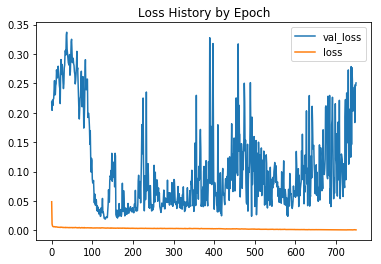

In [34]:
history_df.plot(y = ['val_loss', 'loss'], title = 'Loss History by Epoch')

The overall loss decreases and validation loss seem to decrease a great deal in the first few epochs, but the validation loss is very noisy after about 100 epochs, even though the overall loss seems to continue to decrease.  We choose 100 epochs moving forward as this seems to be a good trade-off zone where we might not be running into overfitting.

#### Dropout Amount

Now, we consider dropout amount (percentage of weights dropped in each iteration).

Train on 884 samples, validate on 156 samples
Epoch 1/100
884/884 [==============================] - 5s 5ms/step - loss: 0.0606 - acc: 0.0011 - val_loss: 0.1111 - val_acc: 0.0000e+00
Epoch 2/100
884/884 [==============================] - 1s 886us/step - loss: 0.0119 - acc: 0.0011 - val_loss: 0.0924 - val_acc: 0.0000e+00
Epoch 3/100
884/884 [==============================] - 1s 787us/step - loss: 0.0097 - acc: 0.0011 - val_loss: 0.0843 - val_acc: 0.0000e+00
Epoch 4/100
884/884 [==============================] - 1s 722us/step - loss: 0.0085 - acc: 0.0011 - val_loss: 0.0823 - val_acc: 0.0000e+00
Epoch 5/100
884/884 [==============================] - 1s 910us/step - loss: 0.0079 - acc: 0.0011 - val_loss: 0.0855 - val_acc: 0.0000e+00
Epoch 6/100
884/884 [==============================] - 1s 829us/step - loss: 0.0077 - acc: 0.0011 - val_loss: 0.0900 - val_acc: 0.0000e+00
Epoch 7/100
884/884 [==============================] - 1s 884us/step - loss: 0.0073 - acc: 0.0011 - val_loss: 0.0901 - val

884/884 [==============================] - 1s 769us/step - loss: 0.0066 - acc: 0.0011 - val_loss: 0.1005 - val_acc: 0.0000e+00
Epoch 17/100
884/884 [==============================] - 1s 731us/step - loss: 0.0061 - acc: 0.0011 - val_loss: 0.0941 - val_acc: 0.0000e+00
Epoch 18/100
884/884 [==============================] - 1s 725us/step - loss: 0.0059 - acc: 0.0011 - val_loss: 0.0873 - val_acc: 0.0000e+00
Epoch 19/100
884/884 [==============================] - 1s 729us/step - loss: 0.0058 - acc: 0.0011 - val_loss: 0.0889 - val_acc: 0.0000e+00
Epoch 20/100
884/884 [==============================] - 1s 732us/step - loss: 0.0065 - acc: 0.0011 - val_loss: 0.0891 - val_acc: 0.0000e+00
Epoch 21/100
884/884 [==============================] - 1s 734us/step - loss: 0.0063 - acc: 0.0011 - val_loss: 0.0863 - val_acc: 0.0000e+00
Epoch 22/100
884/884 [==============================] - 1s 729us/step - loss: 0.0064 - acc: 0.0011 - val_loss: 0.0897 - val_acc: 0.0000e+00
Epoch 23/100
884/884 [===========

884/884 [==============================] - 1s 727us/step - loss: 0.0059 - acc: 0.0011 - val_loss: 0.0930 - val_acc: 0.0000e+00
Epoch 32/100
884/884 [==============================] - 1s 739us/step - loss: 0.0063 - acc: 0.0011 - val_loss: 0.0905 - val_acc: 0.0000e+00
Epoch 33/100
884/884 [==============================] - 1s 723us/step - loss: 0.0056 - acc: 0.0011 - val_loss: 0.0915 - val_acc: 0.0000e+00
Epoch 34/100
884/884 [==============================] - 1s 740us/step - loss: 0.0057 - acc: 0.0011 - val_loss: 0.0906 - val_acc: 0.0000e+00
Epoch 35/100
884/884 [==============================] - 1s 727us/step - loss: 0.0057 - acc: 0.0011 - val_loss: 0.0859 - val_acc: 0.0000e+00
Epoch 36/100
884/884 [==============================] - 1s 725us/step - loss: 0.0055 - acc: 0.0011 - val_loss: 0.0818 - val_acc: 0.0000e+00
Epoch 37/100
884/884 [==============================] - 1s 731us/step - loss: 0.0053 - acc: 0.0011 - val_loss: 0.0845 - val_acc: 0.0000e+00
Epoch 38/100
884/884 [===========

884/884 [==============================] - 1s 861us/step - loss: 0.0054 - acc: 0.0011 - val_loss: 0.1422 - val_acc: 0.0000e+00
Epoch 47/100
884/884 [==============================] - 1s 895us/step - loss: 0.0051 - acc: 0.0011 - val_loss: 0.1375 - val_acc: 0.0000e+00
Epoch 48/100
884/884 [==============================] - 1s 721us/step - loss: 0.0050 - acc: 0.0011 - val_loss: 0.1349 - val_acc: 0.0000e+00
Epoch 49/100
884/884 [==============================] - 1s 736us/step - loss: 0.0051 - acc: 0.0011 - val_loss: 0.1370 - val_acc: 0.0000e+00
Epoch 50/100
884/884 [==============================] - 1s 754us/step - loss: 0.0049 - acc: 0.0011 - val_loss: 0.1444 - val_acc: 0.0000e+00
Epoch 51/100
884/884 [==============================] - 1s 736us/step - loss: 0.0050 - acc: 0.0011 - val_loss: 0.1475 - val_acc: 0.0000e+00
Epoch 52/100
884/884 [==============================] - 1s 758us/step - loss: 0.0047 - acc: 0.0011 - val_loss: 0.1407 - val_acc: 0.0000e+00
Epoch 53/100
884/884 [===========

884/884 [==============================] - 1s 768us/step - loss: 0.0049 - acc: 0.0011 - val_loss: 0.0903 - val_acc: 0.0000e+00
Epoch 62/100
884/884 [==============================] - 1s 746us/step - loss: 0.0049 - acc: 0.0011 - val_loss: 0.0806 - val_acc: 0.0000e+00
Epoch 63/100
884/884 [==============================] - 1s 767us/step - loss: 0.0049 - acc: 0.0011 - val_loss: 0.0741 - val_acc: 0.0000e+00
Epoch 64/100
884/884 [==============================] - 1s 757us/step - loss: 0.0047 - acc: 0.0011 - val_loss: 0.0811 - val_acc: 0.0000e+00
Epoch 65/100
884/884 [==============================] - 1s 738us/step - loss: 0.0047 - acc: 0.0011 - val_loss: 0.0855 - val_acc: 0.0000e+00
Epoch 66/100
884/884 [==============================] - 1s 739us/step - loss: 0.0047 - acc: 0.0011 - val_loss: 0.0814 - val_acc: 0.0000e+00
Epoch 67/100
884/884 [==============================] - 1s 734us/step - loss: 0.0049 - acc: 0.0011 - val_loss: 0.0786 - val_acc: 0.0000e+00
Epoch 68/100
884/884 [===========

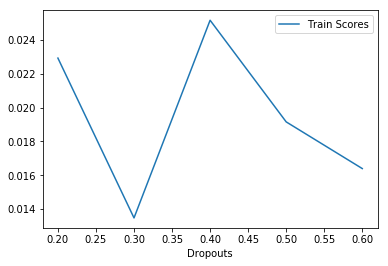

In [35]:
#look at dropout
#use training score as metric (should really only score on test set when done.)
#set up parameters
seq_length = 30
fut_point = 5
train_split = 0.85
neurons = [128, 128, 16]
epochs = 100
batch_size = 64
validation_split = 0.15
model_path = 'dummy_path.h5'

#set up variances of neuron size
dropout_list = [0.2, 0.3, 0.4, 0.5, 0.6]

#create lists to store results
dropouts = []
train_scores = []

#iterate
for dropout in dropout_list:
    dropouts.append(dropout)
    
    train, test, train_preds, test_preds, train_score, test_score = fit_generic_LSTM_model(df, seq_length, 
                                                                                                     fut_point, 
                                                                                                     train_split, 
                                                                                                     neuron_length, 
                                                                                                     dropout, 
                                                                                                     epochs, 
                                                                                                     batch_size,
                                                                                                     validation_split, 
                                                                                                     model_path)
    
    train_scores.append(train_score[0])
    
#create dataframe
results = pd.DataFrame({'Dropouts': dropouts, 'Train Scores': train_scores})

results.plot(x = 'Dropouts', y = 'Train Scores')

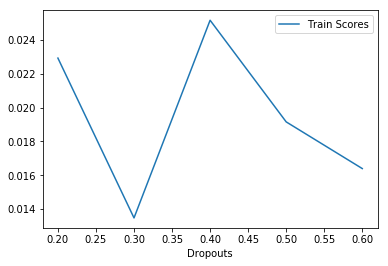

In [36]:
#plot results
results.plot(x = 'Dropouts', y = 'Train Scores')

We see that the dropout value of 0.30 is best according to our training scores.

#### Training Split

We try several different train/test split sizes to get the optimal one.

In [23]:
#look at train/test split
#use training score as metric (should really only score on test set when done.)
#set up parameters
seq_length = 30
fut_point = 5
dropout = 0.3
neurons = [128, 128, 16]
epochs = 100
batch_size = 64
validation_split = 0.15
model_path = 'dummy_path.h5'

#set up variances of neuron size
split_list = [0.75, 0.8, 0.85, 0.9]

#create lists to store results
train_splits = []
train_scores = []

#iterate
for train_split in split_list:
    train_splits.append(train_split)
    
    train, test, train_preds, test_preds, train_score, test_score = fit_generic_LSTM_model(df, seq_length, 
                                                                                                     fut_point, 
                                                                                                     train_split, 
                                                                                                     neurons, 
                                                                                                     dropout, 
                                                                                                     epochs, 
                                                                                                     batch_size,
                                                                                                     validation_split, 
                                                                                                     model_path)
    
    train_scores.append(train_score[0])
    
#create dataframe
results = pd.DataFrame({'Train_Test_Splits': train_splits, 'Train Scores': train_scores})

Train on 780 samples, validate on 138 samples
Epoch 1/100
780/780 [==============================] - 2s 3ms/step - loss: 0.0462 - acc: 0.0000e+00 - val_loss: 0.0436 - val_acc: 0.0072
Epoch 2/100
780/780 [==============================] - 1s 982us/step - loss: 0.0192 - acc: 0.0013 - val_loss: 0.0373 - val_acc: 0.0072
Epoch 3/100
780/780 [==============================] - 1s 972us/step - loss: 0.0140 - acc: 0.0013 - val_loss: 0.0201 - val_acc: 0.0072
Epoch 4/100
780/780 [==============================] - 1s 1ms/step - loss: 0.0143 - acc: 0.0013 - val_loss: 0.0277 - val_acc: 0.0072
Epoch 5/100
780/780 [==============================] - 1s 1ms/step - loss: 0.0132 - acc: 0.0013 - val_loss: 0.0369 - val_acc: 0.0072
Epoch 6/100
780/780 [==============================] - 1s 1ms/step - loss: 0.0122 - acc: 0.0013 - val_loss: 0.0188 - val_acc: 0.0072
Epoch 7/100
780/780 [==============================] - 1s 1ms/step - loss: 0.0119 - acc: 0.0013 - val_loss: 0.0241 - val_acc: 0.0072
Epoch 8/100
780

Epoch 62/100
780/780 [==============================] - 1s 1ms/step - loss: 0.0098 - acc: 0.0013 - val_loss: 0.0186 - val_acc: 0.0072
Epoch 63/100
780/780 [==============================] - 1s 1ms/step - loss: 0.0097 - acc: 0.0013 - val_loss: 0.0177 - val_acc: 0.0072
Epoch 64/100
780/780 [==============================] - 1s 1ms/step - loss: 0.0104 - acc: 0.0013 - val_loss: 0.0152 - val_acc: 0.0072
Epoch 65/100
780/780 [==============================] - 1s 981us/step - loss: 0.0116 - acc: 0.0013 - val_loss: 0.0156 - val_acc: 0.0072
Epoch 66/100
780/780 [==============================] - 1s 985us/step - loss: 0.0096 - acc: 0.0013 - val_loss: 0.0202 - val_acc: 0.0072
Epoch 67/100
780/780 [==============================] - 1s 999us/step - loss: 0.0094 - acc: 0.0013 - val_loss: 0.0188 - val_acc: 0.0072
Epoch 68/100
780/780 [==============================] - 1s 1ms/step - loss: 0.0097 - acc: 0.0013 - val_loss: 0.0162 - val_acc: 0.0072
Epoch 69/100
780/780 [==============================] - 

Epoch 21/100
832/832 [==============================] - 1s 956us/step - loss: 0.0049 - acc: 0.0012 - val_loss: 0.1535 - val_acc: 0.0000e+00
Epoch 22/100
832/832 [==============================] - 1s 979us/step - loss: 0.0053 - acc: 0.0012 - val_loss: 0.1508 - val_acc: 0.0000e+00
Epoch 23/100
832/832 [==============================] - 1s 971us/step - loss: 0.0049 - acc: 0.0012 - val_loss: 0.1556 - val_acc: 0.0000e+00
Epoch 24/100
832/832 [==============================] - 1s 1ms/step - loss: 0.0051 - acc: 0.0012 - val_loss: 0.1578 - val_acc: 0.0000e+00
Epoch 25/100
832/832 [==============================] - 1s 1ms/step - loss: 0.0051 - acc: 0.0012 - val_loss: 0.1572 - val_acc: 0.0000e+00
Epoch 26/100
832/832 [==============================] - 1s 1ms/step - loss: 0.0051 - acc: 0.0012 - val_loss: 0.1613 - val_acc: 0.0000e+00
Epoch 27/100
832/832 [==============================] - 1s 1ms/step - loss: 0.0050 - acc: 0.0012 - val_loss: 0.1579 - val_acc: 0.0000e+00
Epoch 28/100
832/832 [======

Epoch 80/100
832/832 [==============================] - 1s 1ms/step - loss: 0.0044 - acc: 0.0012 - val_loss: 0.1537 - val_acc: 0.0000e+00
Epoch 81/100
832/832 [==============================] - 1s 1ms/step - loss: 0.0041 - acc: 0.0012 - val_loss: 0.1738 - val_acc: 0.0000e+00
Epoch 82/100
832/832 [==============================] - 1s 1ms/step - loss: 0.0045 - acc: 0.0012 - val_loss: 0.1783 - val_acc: 0.0000e+00
Epoch 83/100
832/832 [==============================] - 1s 1ms/step - loss: 0.0042 - acc: 0.0012 - val_loss: 0.1729 - val_acc: 0.0000e+00
Epoch 84/100
832/832 [==============================] - 1s 1ms/step - loss: 0.0045 - acc: 0.0012 - val_loss: 0.1858 - val_acc: 0.0000e+00
Epoch 85/100
832/832 [==============================] - 1s 1ms/step - loss: 0.0044 - acc: 0.0012 - val_loss: 0.1841 - val_acc: 0.0000e+00
Epoch 86/100
832/832 [==============================] - 1s 1ms/step - loss: 0.0043 - acc: 0.0012 - val_loss: 0.1713 - val_acc: 0.0000e+00
Epoch 87/100
832/832 [============

Epoch 38/100
884/884 [==============================] - 1s 1ms/step - loss: 0.0047 - acc: 0.0011 - val_loss: 0.0937 - val_acc: 0.0000e+00
Epoch 39/100
884/884 [==============================] - 1s 1ms/step - loss: 0.0045 - acc: 0.0011 - val_loss: 0.0999 - val_acc: 0.0000e+00
Epoch 40/100
884/884 [==============================] - 1s 1ms/step - loss: 0.0047 - acc: 0.0011 - val_loss: 0.1056 - val_acc: 0.0000e+00
Epoch 41/100
884/884 [==============================] - 1s 987us/step - loss: 0.0046 - acc: 0.0011 - val_loss: 0.1187 - val_acc: 0.0000e+00
Epoch 42/100
884/884 [==============================] - 1s 1ms/step - loss: 0.0050 - acc: 0.0011 - val_loss: 0.1134 - val_acc: 0.0000e+00
Epoch 43/100
884/884 [==============================] - 1s 1ms/step - loss: 0.0049 - acc: 0.0011 - val_loss: 0.0933 - val_acc: 0.0000e+00
Epoch 44/100
884/884 [==============================] - 1s 1ms/step - loss: 0.0047 - acc: 0.0011 - val_loss: 0.0890 - val_acc: 0.0000e+00
Epoch 45/100
884/884 [==========

935/935 [==============================] - 1s 1ms/step - loss: 0.0049 - acc: 0.0011 - val_loss: 0.1988 - val_acc: 0.0060
Epoch 57/100
935/935 [==============================] - 1s 1ms/step - loss: 0.0051 - acc: 0.0011 - val_loss: 0.1702 - val_acc: 0.0060
Epoch 58/100
935/935 [==============================] - 1s 1ms/step - loss: 0.0054 - acc: 0.0011 - val_loss: 0.1665 - val_acc: 0.0060
Epoch 59/100
935/935 [==============================] - 1s 1ms/step - loss: 0.0050 - acc: 0.0011 - val_loss: 0.1523 - val_acc: 0.0060
Epoch 60/100
935/935 [==============================] - 1s 1ms/step - loss: 0.0050 - acc: 0.0011 - val_loss: 0.1335 - val_acc: 0.0060
Epoch 61/100
935/935 [==============================] - 1s 989us/step - loss: 0.0050 - acc: 0.0011 - val_loss: 0.2164 - val_acc: 0.0060
Epoch 62/100
935/935 [==============================] - 1s 1ms/step - loss: 0.0049 - acc: 0.0011 - val_loss: 0.2221 - val_acc: 0.0060
Epoch 63/100
935/935 [==============================] - 1s 1ms/step - los

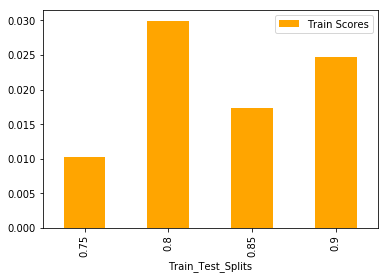

In [27]:
#plot results
results.plot.bar(x = 'Train_Test_Splits', y = 'Train Scores', color = 'orange')

Due to the way train/test split works with this time series data, we will actually take a look at a graph for this one after training a model.  It may be that training/test performance is different.  We will test with the best (lowest) score of 0.75/0.25 split.

In [28]:
#train a model with 0.75 train/test split
seq_length = 30
fut_point = 5
train_split = 0.75
neurons = [128, 128, 16]
epochs = 100
batch_size = 64
validation_split = 0.15
dropout = 0.3
model_path = 'three_quarters_split.h5'
y_train3, y_test3, y_train_preds3, y_test_preds3, train_score3, test_score3 = fit_generic_LSTM_model(df, 
                                                                                                     seq_length, 
                                                                                                     fut_point, 
                                                                                                     train_split, 
                                                                                                     neurons, 
                                                                                                     dropout, 
                                                                                                     epochs, 
                                                                                                     batch_size,
                                                                                                     validation_split, 
                                                                                                     model_path)

Train on 780 samples, validate on 138 samples
Epoch 1/100
780/780 [==============================] - 4s 4ms/step - loss: 0.0458 - acc: 0.0013 - val_loss: 0.0393 - val_acc: 0.0072
Epoch 2/100
780/780 [==============================] - 1s 1ms/step - loss: 0.0173 - acc: 0.0000e+00 - val_loss: 0.0208 - val_acc: 0.0072
Epoch 3/100
780/780 [==============================] - 1s 1ms/step - loss: 0.0133 - acc: 0.0013 - val_loss: 0.0345 - val_acc: 0.0072
Epoch 4/100
780/780 [==============================] - 1s 1ms/step - loss: 0.0136 - acc: 0.0013 - val_loss: 0.0259 - val_acc: 0.0072
Epoch 5/100
780/780 [==============================] - 1s 1ms/step - loss: 0.0127 - acc: 0.0013 - val_loss: 0.0187 - val_acc: 0.0072
Epoch 6/100
780/780 [==============================] - 1s 1ms/step - loss: 0.0125 - acc: 0.0013 - val_loss: 0.0261 - val_acc: 0.0072
Epoch 7/100
780/780 [==============================] - 1s 1ms/step - loss: 0.0120 - acc: 0.0013 - val_loss: 0.0208 - val_acc: 0.0072
Epoch 8/100
780/780

Epoch 62/100
780/780 [==============================] - 1s 1ms/step - loss: 0.0102 - acc: 0.0013 - val_loss: 0.0153 - val_acc: 0.0072
Epoch 63/100
780/780 [==============================] - 1s 1ms/step - loss: 0.0098 - acc: 0.0013 - val_loss: 0.0185 - val_acc: 0.0072
Epoch 64/100
780/780 [==============================] - 1s 1ms/step - loss: 0.0098 - acc: 0.0013 - val_loss: 0.0220 - val_acc: 0.0072
Epoch 65/100
780/780 [==============================] - 1s 1ms/step - loss: 0.0099 - acc: 0.0013 - val_loss: 0.0153 - val_acc: 0.0072
Epoch 66/100
780/780 [==============================] - 1s 1ms/step - loss: 0.0093 - acc: 0.0013 - val_loss: 0.0229 - val_acc: 0.0072
Epoch 67/100
780/780 [==============================] - 1s 1ms/step - loss: 0.0100 - acc: 0.0013 - val_loss: 0.0170 - val_acc: 0.0072
Epoch 68/100
780/780 [==============================] - 1s 1ms/step - loss: 0.0097 - acc: 0.0013 - val_loss: 0.0170 - val_acc: 0.0072
Epoch 69/100
780/780 [==============================] - 1s 1ms

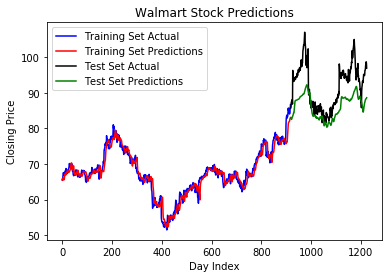

In [29]:
#plot
make_results_plot(y_train3, y_test3, y_train_preds3, y_test_preds3)

We see that a 0.75 train/test split actually does not do well as the scale is wrong for the test set.  We will still use a split of 0.85 going forward.

We will now try several different validation set splits (a validation set is the portion of the training set used to test the training sets performance in each epoch.

In [30]:
#look at validation split
#use training score as metric (should really only score on test set when done.)
#set up parameters
seq_length = 30
fut_point = 5
dropout = 0.3
neurons = [128, 128, 16]
epochs = 100
batch_size = 64
train_split = 0.85
model_path = 'dummy_path.h5'

#set up variances of neuron size
split_list = [0.1, 0.15, 0.2, 0.25]

#create lists to store results
validation_splits = []
train_scores = []

#iterate
for validation_split in split_list:
    validation_splits.append(validation_split)
    
    train, test, train_preds, test_preds, train_score, test_score = fit_generic_LSTM_model(df, seq_length, 
                                                                                                     fut_point, 
                                                                                                     train_split, 
                                                                                                     neurons, 
                                                                                                     dropout, 
                                                                                                     epochs, 
                                                                                                     batch_size,
                                                                                                     validation_split, 
                                                                                                     model_path)
    
    train_scores.append(train_score[0])
    
#create dataframe
results = pd.DataFrame({'Validation Split': train_splits, 'Train Scores': train_scores})

Train on 936 samples, validate on 104 samples
Epoch 1/100
936/936 [==============================] - 4s 5ms/step - loss: 0.0366 - acc: 0.0011 - val_loss: 0.1240 - val_acc: 0.0000e+00
Epoch 2/100
936/936 [==============================] - 1s 1ms/step - loss: 0.0115 - acc: 0.0011 - val_loss: 0.0263 - val_acc: 0.0096
Epoch 3/100
936/936 [==============================] - 1s 1ms/step - loss: 0.0076 - acc: 0.0011 - val_loss: 0.1011 - val_acc: 0.0096
Epoch 4/100
936/936 [==============================] - 1s 1ms/step - loss: 0.0074 - acc: 0.0011 - val_loss: 0.1471 - val_acc: 0.0096
Epoch 5/100
936/936 [==============================] - 1s 1ms/step - loss: 0.0070 - acc: 0.0011 - val_loss: 0.0909 - val_acc: 0.0096
Epoch 6/100
936/936 [==============================] - 1s 1ms/step - loss: 0.0068 - acc: 0.0011 - val_loss: 0.1524 - val_acc: 0.0096
Epoch 7/100
936/936 [==============================] - 1s 1ms/step - loss: 0.0071 - acc: 0.0011 - val_loss: 0.1208 - val_acc: 0.0096
Epoch 8/100
936/936

Epoch 62/100
936/936 [==============================] - 1s 1ms/step - loss: 0.0049 - acc: 0.0011 - val_loss: 0.1313 - val_acc: 0.0096
Epoch 63/100
936/936 [==============================] - 1s 1ms/step - loss: 0.0050 - acc: 0.0011 - val_loss: 0.0765 - val_acc: 0.0096
Epoch 64/100
936/936 [==============================] - 1s 1ms/step - loss: 0.0054 - acc: 0.0011 - val_loss: 0.2015 - val_acc: 0.0096
Epoch 65/100
936/936 [==============================] - 1s 1ms/step - loss: 0.0049 - acc: 0.0011 - val_loss: 0.0968 - val_acc: 0.0096
Epoch 66/100
936/936 [==============================] - 1s 1ms/step - loss: 0.0049 - acc: 0.0011 - val_loss: 0.1191 - val_acc: 0.0096
Epoch 67/100
936/936 [==============================] - 1s 1ms/step - loss: 0.0050 - acc: 0.0011 - val_loss: 0.1120 - val_acc: 0.0096
Epoch 68/100
936/936 [==============================] - 1s 1ms/step - loss: 0.0048 - acc: 0.0011 - val_loss: 0.0905 - val_acc: 0.0096
Epoch 69/100
936/936 [==============================] - 1s 1ms

884/884 [==============================] - 1s 1ms/step - loss: 0.0053 - acc: 0.0011 - val_loss: 0.1306 - val_acc: 0.0000e+00
Epoch 22/100
884/884 [==============================] - 1s 1ms/step - loss: 0.0053 - acc: 0.0011 - val_loss: 0.1330 - val_acc: 0.0000e+00
Epoch 23/100
884/884 [==============================] - 1s 1ms/step - loss: 0.0053 - acc: 0.0011 - val_loss: 0.1427 - val_acc: 0.0000e+00
Epoch 24/100
884/884 [==============================] - 1s 1ms/step - loss: 0.0049 - acc: 0.0011 - val_loss: 0.1295 - val_acc: 0.0000e+00
Epoch 25/100
884/884 [==============================] - 1s 1ms/step - loss: 0.0049 - acc: 0.0011 - val_loss: 0.1290 - val_acc: 0.0000e+00
Epoch 26/100
884/884 [==============================] - 1s 1ms/step - loss: 0.0048 - acc: 0.0011 - val_loss: 0.1269 - val_acc: 0.0000e+00
Epoch 27/100
884/884 [==============================] - 1s 1ms/step - loss: 0.0048 - acc: 0.0011 - val_loss: 0.1254 - val_acc: 0.0000e+00
Epoch 28/100
884/884 [=========================

832/832 [==============================] - 1s 1ms/step - loss: 0.0047 - acc: 0.0012 - val_loss: 0.1161 - val_acc: 0.0000e+00
Epoch 39/100
832/832 [==============================] - 1s 1ms/step - loss: 0.0049 - acc: 0.0012 - val_loss: 0.1149 - val_acc: 0.0000e+00
Epoch 40/100
832/832 [==============================] - 1s 1ms/step - loss: 0.0053 - acc: 0.0012 - val_loss: 0.0867 - val_acc: 0.0000e+00
Epoch 41/100
832/832 [==============================] - 1s 1ms/step - loss: 0.0050 - acc: 0.0012 - val_loss: 0.0798 - val_acc: 0.0000e+00
Epoch 42/100
832/832 [==============================] - 1s 1ms/step - loss: 0.0047 - acc: 0.0012 - val_loss: 0.0915 - val_acc: 0.0000e+00
Epoch 43/100
832/832 [==============================] - 1s 1ms/step - loss: 0.0050 - acc: 0.0012 - val_loss: 0.0974 - val_acc: 0.0000e+00
Epoch 44/100
832/832 [==============================] - 1s 1ms/step - loss: 0.0051 - acc: 0.0012 - val_loss: 0.0925 - val_acc: 0.0000e+00
Epoch 45/100
832/832 [=========================

780/780 [==============================] - 1s 1ms/step - loss: 0.0058 - acc: 0.0013 - val_loss: 0.1249 - val_acc: 0.0000e+00
Epoch 56/100
780/780 [==============================] - 1s 1ms/step - loss: 0.0046 - acc: 0.0013 - val_loss: 0.1171 - val_acc: 0.0000e+00
Epoch 57/100
780/780 [==============================] - 1s 1ms/step - loss: 0.0047 - acc: 0.0013 - val_loss: 0.1157 - val_acc: 0.0000e+00
Epoch 58/100
780/780 [==============================] - 1s 1ms/step - loss: 0.0045 - acc: 0.0013 - val_loss: 0.1215 - val_acc: 0.0000e+00
Epoch 59/100
780/780 [==============================] - 1s 1ms/step - loss: 0.0045 - acc: 0.0013 - val_loss: 0.1238 - val_acc: 0.0000e+00
Epoch 60/100
780/780 [==============================] - 1s 1ms/step - loss: 0.0048 - acc: 0.0013 - val_loss: 0.1263 - val_acc: 0.0000e+00
Epoch 61/100
780/780 [==============================] - 1s 1ms/step - loss: 0.0045 - acc: 0.0013 - val_loss: 0.1223 - val_acc: 0.0000e+00
Epoch 62/100
780/780 [=========================

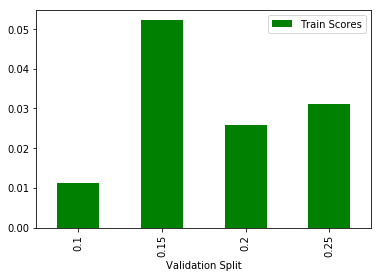

In [32]:
results = pd.DataFrame({'Validation Split': validation_splits, 'Train Scores': train_scores})
results.plot.bar(x = 'Validation Split', y = 'Train Scores', color = 'green')

We will use a validation split of 0.1 as it gives the best performance.

#### Batch Size

Finally, we will try a few different batch sizes (how much data is fed at a time).

In [33]:
#look at batch size
#use training score as metric (should really only score on test set when done.)
#set up parameters
seq_length = 30
fut_point = 5
dropout = 0.3
neurons = [128, 128, 16]
epochs = 100
validation_split = 0.1
train_split = 0.85
model_path = 'dummy_path.h5'

#set up variances of neuron size
sizes = [16, 32, 64]

#create lists to store results
batch_sizes = []
train_scores = []

#iterate
for batch_size in sizes:
    batch_sizes.append(batch_size)
    
    train, test, train_preds, test_preds, train_score, test_score = fit_generic_LSTM_model(df, seq_length, 
                                                                                                     fut_point, 
                                                                                                     train_split, 
                                                                                                     neurons, 
                                                                                                     dropout, 
                                                                                                     epochs, 
                                                                                                     batch_size,
                                                                                                     validation_split, 
                                                                                                     model_path)
    
    train_scores.append(train_score[0])
    
#create dataframe
results = pd.DataFrame({'Batch Size': train_splits, 'Train Scores': train_scores})

Train on 936 samples, validate on 104 samples
Epoch 1/100
936/936 [==============================] - 8s 8ms/step - loss: 0.0349 - acc: 0.0011 - val_loss: 0.0597 - val_acc: 0.0096
Epoch 2/100
936/936 [==============================] - 3s 3ms/step - loss: 0.0087 - acc: 0.0011 - val_loss: 0.0901 - val_acc: 0.0096
Epoch 3/100
936/936 [==============================] - 3s 3ms/step - loss: 0.0076 - acc: 0.0011 - val_loss: 0.0636 - val_acc: 0.0096
Epoch 4/100
936/936 [==============================] - 3s 3ms/step - loss: 0.0069 - acc: 0.0011 - val_loss: 0.0481 - val_acc: 0.0096
Epoch 5/100
936/936 [==============================] - 3s 4ms/step - loss: 0.0069 - acc: 0.0011 - val_loss: 0.0354 - val_acc: 0.0096
Epoch 6/100
936/936 [==============================] - 3s 3ms/step - loss: 0.0069 - acc: 0.0011 - val_loss: 0.0368 - val_acc: 0.0096
Epoch 7/100
936/936 [==============================] - 3s 3ms/step - loss: 0.0066 - acc: 0.0011 - val_loss: 0.1094 - val_acc: 0.0096
Epoch 8/100
936/936 [==

Epoch 62/100
936/936 [==============================] - 3s 3ms/step - loss: 0.0051 - acc: 0.0011 - val_loss: 0.0237 - val_acc: 0.0096
Epoch 63/100
936/936 [==============================] - 3s 3ms/step - loss: 0.0044 - acc: 0.0011 - val_loss: 0.0347 - val_acc: 0.0096
Epoch 64/100
936/936 [==============================] - 3s 3ms/step - loss: 0.0048 - acc: 0.0011 - val_loss: 0.0240 - val_acc: 0.0096
Epoch 65/100
936/936 [==============================] - 3s 4ms/step - loss: 0.0046 - acc: 0.0011 - val_loss: 0.0383 - val_acc: 0.0096
Epoch 66/100
936/936 [==============================] - 3s 3ms/step - loss: 0.0044 - acc: 0.0011 - val_loss: 0.0266 - val_acc: 0.0096
Epoch 67/100
936/936 [==============================] - 3s 3ms/step - loss: 0.0047 - acc: 0.0011 - val_loss: 0.1499 - val_acc: 0.0096
Epoch 68/100
936/936 [==============================] - 3s 3ms/step - loss: 0.0045 - acc: 0.0011 - val_loss: 0.0291 - val_acc: 0.0096
Epoch 69/100
936/936 [==============================] - 3s 3ms

Epoch 22/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0056 - acc: 0.0011 - val_loss: 0.1563 - val_acc: 0.0096
Epoch 23/100
936/936 [==============================] - 1s 2ms/step - loss: 0.0054 - acc: 0.0011 - val_loss: 0.1524 - val_acc: 0.0096
Epoch 24/100
936/936 [==============================] - 1s 2ms/step - loss: 0.0056 - acc: 0.0011 - val_loss: 0.0881 - val_acc: 0.0096
Epoch 25/100
936/936 [==============================] - 1s 2ms/step - loss: 0.0059 - acc: 0.0011 - val_loss: 0.0309 - val_acc: 0.0096
Epoch 26/100
936/936 [==============================] - 1s 2ms/step - loss: 0.0054 - acc: 0.0011 - val_loss: 0.1351 - val_acc: 0.0096
Epoch 27/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0050 - acc: 0.0011 - val_loss: 0.1069 - val_acc: 0.0096
Epoch 28/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0053 - acc: 0.0011 - val_loss: 0.0599 - val_acc: 0.0096
Epoch 29/100
936/936 [==============================] - 2s 2ms

936/936 [==============================] - 1s 971us/step - loss: 0.0062 - acc: 0.0011 - val_loss: 0.1461 - val_acc: 0.0096
Epoch 43/100
936/936 [==============================] - 1s 966us/step - loss: 0.0064 - acc: 0.0011 - val_loss: 0.1065 - val_acc: 0.0096
Epoch 44/100
936/936 [==============================] - 1s 1ms/step - loss: 0.0053 - acc: 0.0011 - val_loss: 0.1608 - val_acc: 0.0096
Epoch 45/100
936/936 [==============================] - 1s 1ms/step - loss: 0.0053 - acc: 0.0011 - val_loss: 0.1305 - val_acc: 0.0096
Epoch 46/100
936/936 [==============================] - 1s 1ms/step - loss: 0.0055 - acc: 0.0011 - val_loss: 0.0963 - val_acc: 0.0096
Epoch 47/100
936/936 [==============================] - 1s 1ms/step - loss: 0.0052 - acc: 0.0011 - val_loss: 0.1446 - val_acc: 0.0096
Epoch 48/100
936/936 [==============================] - 1s 1ms/step - loss: 0.0050 - acc: 0.0011 - val_loss: 0.1058 - val_acc: 0.0096
Epoch 49/100
936/936 [==============================] - 1s 1ms/step - l

ValueError: arrays must all be same length

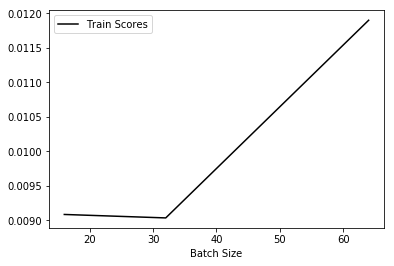

In [36]:
results = pd.DataFrame({'Batch Size': batch_sizes, 'Train Scores': train_scores})
results.plot(x = 'Batch Size', y = 'Train Scores', color = 'black')

We will use a batch size of 32.

### Re-visiting Time Windows

With selected hyperparameters, we can now look at and graph results for different sequence lengths and future points.

We begin with our standard 30 day sequence length and a 5 day future point.

In [39]:
#train a model with
seq_length = 30
fut_point = 5
train_split = 0.85
neurons = [128, 128, 16]
epochs = 100
batch_size = 32
validation_split = 0.1
dropout = 0.3
model_path = 'final_model.h5'
y_train3, y_test3, y_train_preds3, y_test_preds3, train_score3, test_score3 = fit_generic_LSTM_model(df, 
                                                                                                     seq_length, 
                                                                                                     fut_point, 
                                                                                                     train_split, 
                                                                                                     neurons, 
                                                                                                     dropout, 
                                                                                                     epochs, 
                                                                                                     batch_size,
                                                                                                     validation_split, 
                                                                                                     model_path)

Train on 936 samples, validate on 104 samples
Epoch 1/100
936/936 [==============================] - 8s 9ms/step - loss: 0.0335 - acc: 0.0011 - val_loss: 0.0331 - val_acc: 0.0096
Epoch 2/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0082 - acc: 0.0011 - val_loss: 0.1175 - val_acc: 0.0096
Epoch 3/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0070 - acc: 0.0011 - val_loss: 0.1361 - val_acc: 0.0096
Epoch 4/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0069 - acc: 0.0011 - val_loss: 0.1458 - val_acc: 0.0096
Epoch 5/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0065 - acc: 0.0011 - val_loss: 0.1282 - val_acc: 0.0096
Epoch 6/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0067 - acc: 0.0011 - val_loss: 0.2047 - val_acc: 0.0096
Epoch 7/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0069 - acc: 0.0011 - val_loss: 0.1494 - val_acc: 0.0096
Epoch 8/100
936/936 [==

Epoch 62/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0046 - acc: 0.0011 - val_loss: 0.1428 - val_acc: 0.0096
Epoch 63/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0047 - acc: 0.0011 - val_loss: 0.1593 - val_acc: 0.0096
Epoch 64/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0047 - acc: 0.0011 - val_loss: 0.0632 - val_acc: 0.0096
Epoch 65/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0046 - acc: 0.0011 - val_loss: 0.0730 - val_acc: 0.0096
Epoch 66/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0048 - acc: 0.0011 - val_loss: 0.0594 - val_acc: 0.0096
Epoch 67/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0046 - acc: 0.0011 - val_loss: 0.1149 - val_acc: 0.0096
Epoch 68/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0046 - acc: 0.0011 - val_loss: 0.0537 - val_acc: 0.0096
Epoch 69/100
936/936 [==============================] - 2s 2ms

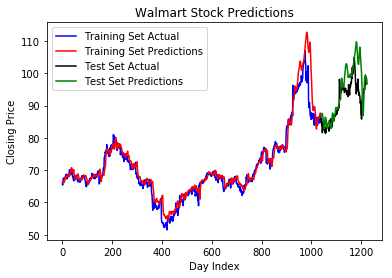

In [40]:
#plot
make_results_plot(y_train3, y_test3, y_train_preds3, y_test_preds3)

This seems to do well enough for now.

Now, we try 5 days sequence 1 day ahead.

In [41]:
#train a model with 5 days sequence, 1 day future point
seq_length = 5
fut_point = 1
train_split = 0.85
neurons = [128, 128, 16]
epochs = 100
batch_size = 32
validation_split = 0.1
dropout = 0.3
model_path = 'final_model_short.h5'
y_train3, y_test3, y_train_preds3, y_test_preds3, train_score3, test_score3 = fit_generic_LSTM_model(df, 
                                                                                                     seq_length, 
                                                                                                     fut_point, 
                                                                                                     train_split, 
                                                                                                     neurons, 
                                                                                                     dropout, 
                                                                                                     epochs, 
                                                                                                     batch_size,
                                                                                                     validation_split, 
                                                                                                     model_path)

Train on 958 samples, validate on 107 samples
Epoch 1/100
958/958 [==============================] - 7s 7ms/step - loss: 0.0317 - acc: 0.0000e+00 - val_loss: 0.1279 - val_acc: 0.0000e+00
Epoch 2/100
958/958 [==============================] - 0s 438us/step - loss: 0.0050 - acc: 0.0010 - val_loss: 0.0393 - val_acc: 0.0093
Epoch 3/100
958/958 [==============================] - 0s 437us/step - loss: 0.0039 - acc: 0.0010 - val_loss: 0.0107 - val_acc: 0.0093
Epoch 4/100
958/958 [==============================] - 0s 412us/step - loss: 0.0040 - acc: 0.0010 - val_loss: 0.0097 - val_acc: 0.0093
Epoch 5/100
958/958 [==============================] - 0s 404us/step - loss: 0.0036 - acc: 0.0010 - val_loss: 0.0091 - val_acc: 0.0093
Epoch 6/100
958/958 [==============================] - 0s 436us/step - loss: 0.0038 - acc: 0.0010 - val_loss: 0.0093 - val_acc: 0.0093
Epoch 7/100
958/958 [==============================] - 0s 437us/step - loss: 0.0037 - acc: 0.0010 - val_loss: 0.0114 - val_acc: 0.0093
Epo

Epoch 61/100
958/958 [==============================] - 0s 439us/step - loss: 0.0025 - acc: 0.0010 - val_loss: 0.0430 - val_acc: 0.0093
Epoch 62/100
958/958 [==============================] - 0s 442us/step - loss: 0.0024 - acc: 0.0010 - val_loss: 0.0220 - val_acc: 0.0093
Epoch 63/100
958/958 [==============================] - 0s 446us/step - loss: 0.0021 - acc: 0.0010 - val_loss: 0.0238 - val_acc: 0.0093
Epoch 64/100
958/958 [==============================] - 0s 441us/step - loss: 0.0021 - acc: 0.0010 - val_loss: 0.0346 - val_acc: 0.0093
Epoch 65/100
958/958 [==============================] - 0s 445us/step - loss: 0.0021 - acc: 0.0010 - val_loss: 0.0273 - val_acc: 0.0093
Epoch 66/100
958/958 [==============================] - 0s 406us/step - loss: 0.0023 - acc: 0.0010 - val_loss: 0.0192 - val_acc: 0.0093
Epoch 67/100
958/958 [==============================] - 0s 424us/step - loss: 0.0021 - acc: 0.0010 - val_loss: 0.0378 - val_acc: 0.0093
Epoch 68/100
958/958 [==========================

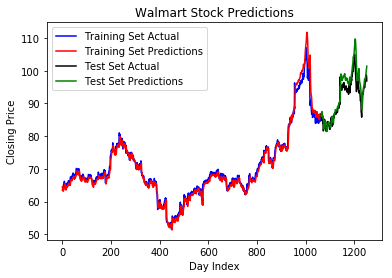

In [42]:
#plot
make_results_plot(y_train3, y_test3, y_train_preds3, y_test_preds3)

This also now has the range in a good place.

We now use 30 days to predict 30 days out.

In [43]:
#train a model with 30 days sequence, 30 day future point
seq_length = 30
fut_point = 30
train_split = 0.85
neurons = [128, 128, 16]
epochs = 100
batch_size = 32
validation_split = 0.1
dropout = 0.3
model_path = 'final_model_months.h5'
y_train3, y_test3, y_train_preds3, y_test_preds3, train_score3, test_score3 = fit_generic_LSTM_model(df, 
                                                                                                     seq_length, 
                                                                                                     fut_point, 
                                                                                                     train_split, 
                                                                                                     neurons, 
                                                                                                     dropout, 
                                                                                                     epochs, 
                                                                                                     batch_size,
                                                                                                     validation_split, 
                                                                                                     model_path)

Train on 917 samples, validate on 102 samples
Epoch 1/100
917/917 [==============================] - 9s 9ms/step - loss: 0.0432 - acc: 0.0011 - val_loss: 0.2430 - val_acc: 0.0000e+00
Epoch 2/100
917/917 [==============================] - 1s 2ms/step - loss: 0.0268 - acc: 0.0011 - val_loss: 0.1091 - val_acc: 0.0000e+00
Epoch 3/100
917/917 [==============================] - 1s 2ms/step - loss: 0.0267 - acc: 0.0011 - val_loss: 0.0940 - val_acc: 0.0000e+00
Epoch 4/100
917/917 [==============================] - 1s 2ms/step - loss: 0.0257 - acc: 0.0011 - val_loss: 0.1411 - val_acc: 0.0098
Epoch 5/100
917/917 [==============================] - 1s 2ms/step - loss: 0.0254 - acc: 0.0011 - val_loss: 0.1514 - val_acc: 0.0098
Epoch 6/100
917/917 [==============================] - 1s 2ms/step - loss: 0.0245 - acc: 0.0011 - val_loss: 0.2494 - val_acc: 0.0098
Epoch 7/100
917/917 [==============================] - 1s 2ms/step - loss: 0.0250 - acc: 0.0011 - val_loss: 0.2669 - val_acc: 0.0098
Epoch 8/100

917/917 [==============================] - 1s 2ms/step - loss: 0.0183 - acc: 0.0011 - val_loss: 0.8832 - val_acc: 0.0000e+00
Epoch 62/100
917/917 [==============================] - 2s 2ms/step - loss: 0.0182 - acc: 0.0011 - val_loss: 1.6965 - val_acc: 0.0000e+00
Epoch 63/100
917/917 [==============================] - 2s 2ms/step - loss: 0.0190 - acc: 0.0011 - val_loss: 0.3479 - val_acc: 0.0098
Epoch 64/100
917/917 [==============================] - 2s 2ms/step - loss: 0.0181 - acc: 0.0011 - val_loss: 0.9412 - val_acc: 0.0000e+00
Epoch 65/100
917/917 [==============================] - 2s 2ms/step - loss: 0.0176 - acc: 0.0011 - val_loss: 0.2073 - val_acc: 0.0098
Epoch 66/100
917/917 [==============================] - 2s 2ms/step - loss: 0.0178 - acc: 0.0011 - val_loss: 1.4747 - val_acc: 0.0000e+00
Epoch 67/100
917/917 [==============================] - 2s 2ms/step - loss: 0.0166 - acc: 0.0011 - val_loss: 0.8020 - val_acc: 0.0000e+00
Epoch 68/100
917/917 [==============================] -

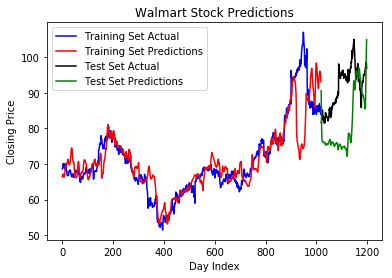

In [44]:
#plot
make_results_plot(y_train3, y_test3, y_train_preds3, y_test_preds3)

That this is not completely bad is nice.  Our magnitude seems to be somewhat more on point.

Now, for a very long conmparison, 180 days sequence for 80 days in the future.

In [46]:
#train a model with 180 days sequence, 80 day future point
seq_length = 180
fut_point = 80
train_split = 0.85
neurons = [128, 128, 16]
epochs = 100
batch_size = 32
validation_split = 0.1
dropout = 0.3
model_path = 'final_model_long.h5'
y_train3, y_test3, y_train_preds3, y_test_preds3, train_score3, test_score3 = fit_generic_LSTM_model(df, 
                                                                                                     seq_length, 
                                                                                                     fut_point, 
                                                                                                     train_split, 
                                                                                                     neurons, 
                                                                                                     dropout, 
                                                                                                     epochs, 
                                                                                                     batch_size,
                                                                                                     validation_split, 
                                                                                                     model_path)

Train on 764 samples, validate on 85 samples
Epoch 1/100
764/764 [==============================] - 16s 22ms/step - loss: 0.1159 - acc: 0.0013 - val_loss: 0.0253 - val_acc: 0.0000e+00
Epoch 2/100
764/764 [==============================] - 8s 10ms/step - loss: 0.1047 - acc: 0.0000e+00 - val_loss: 0.0231 - val_acc: 0.0000e+00
Epoch 3/100
764/764 [==============================] - 8s 10ms/step - loss: 0.1018 - acc: 0.0000e+00 - val_loss: 0.0678 - val_acc: 0.0000e+00
Epoch 4/100
764/764 [==============================] - 8s 10ms/step - loss: 0.0998 - acc: 0.0000e+00 - val_loss: 0.3174 - val_acc: 0.0000e+00
Epoch 5/100
764/764 [==============================] - 8s 11ms/step - loss: 0.0980 - acc: 0.0000e+00 - val_loss: 0.7098 - val_acc: 0.0000e+00
Epoch 6/100
764/764 [==============================] - 8s 10ms/step - loss: 0.0964 - acc: 0.0000e+00 - val_loss: 0.0424 - val_acc: 0.0000e+00
Epoch 7/100
764/764 [==============================] - 7s 10ms/step - loss: 0.0962 - acc: 0.0000e+00 - val

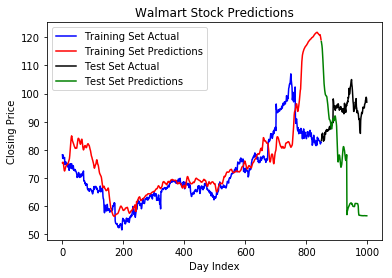

In [47]:
#plot
make_results_plot(y_train3, y_test3, y_train_preds3, y_test_preds3)

This is problematic, but not necessarily surprising.  We still seem to run into issues with very long future time points.  This is to some extent due to the fact that it is easier to predict the stock market on a short time window as the market does not change much over a few days.

### Generic Stock

There are actually 30 Dow Jones Stocks.  We need a function to produce a model for a generic csv filepath.


In [22]:
#function to produce predictions for a generic filepath
def generic_stock_predictions(filepath, stock_name, seq_length, fut_point):
    
    #define variables
    train_split = 0.85
    neurons = [128, 128, 16]
    epochs = 100
    batch_size = 32
    validation_split = 0.1
    dropout = 0.3
    
    #define model path
    model_path = stock_name + '_model.h5'
    
    #read in data frame and drop unnescessary columns
    df = pd.read_csv(filepath)
    df.drop(['volume', 'unadjustedVolume', 'change', 'changePercent', 'vwap', 'label', 
             'changeOverTime'], 1, inplace = True)
    df.set_index('date', inplace = True)
    
    #fit model
    y_train, y_test, y_train_preds, y_test_preds, train_score, test_score = fit_generic_LSTM_model(df, 
                                                                                                     seq_length, 
                                                                                                     fut_point, 
                                                                                                     train_split, 
                                                                                                     neurons, 
                                                                                                     dropout, 
                                                                                                     epochs, 
                                                                                                     batch_size,
                                                                                                     validation_split, 
                                                                                                     model_path)
    
    #return
    return y_train, y_test, y_train_preds, y_test_preds, train_score, test_score

In [3]:
We test this function with our Wal-Mart data.

SyntaxError: invalid syntax (<ipython-input-3-59a59be5020e>, line 1)

In [ ]:
#test
filepath = os.path.join('..', 'Resources', 'WMT.csv')
y_train4, y_test4, y_train_preds4, y_test_preds4, train_score4, test_score4 = generic_stock_predictions(filepath,
                                                                                                       'WMT',
                                                                                                       30, 5)

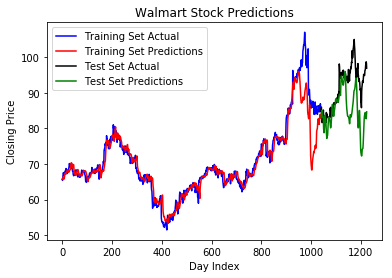

In [50]:
#plot
make_results_plot(y_train4, y_test4, y_train_preds4, y_test_preds4)

We wish to have a function that looks at predicted profitability on the last day of our data set as we wish to test this for all of the stocks in the data set.

In [27]:
#predicted profitability function
def predicted_profit(filepath, stock_name, seq_length, fut_point):
    
    #fit model
    y_train, y_test, y_train_preds, y_test_preds, train_score, test_score = generic_stock_predictions(
        filepath, stock_name, seq_length, fut_point)
    
    #get values
    start_close = y_test[-1-fut_point]
    end_close = y_test[-1]
    pred_close = y_test_preds[-1]
    actual_profit = (end_close - start_close)*100/start_close
    pred_profit = (pred_close - start_close)*100/start_close
    
    #create dictionary for output
    stock_dictionary = {'Stock': stock_name, 'Start Close': start_close, 'End Close': end_close, 
                       'Predicted Close': pred_close, 'Actual Profit': actual_profit, 'Predicted Profit': pred_profit}
    
    return stock_dictionary
    

In [34]:
#test function
filepath = os.path.join('..', 'Resources', 'WMT.csv')
dictionary = predicted_profit(filepath, 'WMT', 30, 5)
dictionary

Train on 936 samples, validate on 104 samples
Epoch 1/100
936/936 [==============================] - 3s 4ms/step - loss: 0.0301 - acc: 0.0011 - val_loss: 0.0287 - val_acc: 0.0096
Epoch 2/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0079 - acc: 0.0011 - val_loss: 0.0769 - val_acc: 0.0096
Epoch 3/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0073 - acc: 0.0011 - val_loss: 0.0965 - val_acc: 0.0096
Epoch 4/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0074 - acc: 0.0011 - val_loss: 0.1170 - val_acc: 0.0096
Epoch 5/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0066 - acc: 0.0011 - val_loss: 0.1411 - val_acc: 0.0096
Epoch 6/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0067 - acc: 0.0011 - val_loss: 0.1715 - val_acc: 0.0096
Epoch 7/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0066 - acc: 0.0011 - val_loss: 0.1453 - val_acc: 0.0096
Epoch 8/100
936/936 [==

Epoch 62/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0046 - acc: 0.0011 - val_loss: 0.1914 - val_acc: 0.0096
Epoch 63/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0044 - acc: 0.0011 - val_loss: 0.0858 - val_acc: 0.0000e+00
Epoch 64/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0044 - acc: 0.0011 - val_loss: 0.0971 - val_acc: 0.0096
Epoch 65/100
936/936 [==============================] - 1s 2ms/step - loss: 0.0048 - acc: 0.0011 - val_loss: 0.0405 - val_acc: 0.0096
Epoch 66/100
936/936 [==============================] - 1s 2ms/step - loss: 0.0047 - acc: 0.0011 - val_loss: 0.0623 - val_acc: 0.0000e+00
Epoch 67/100
936/936 [==============================] - 1s 2ms/step - loss: 0.0046 - acc: 0.0011 - val_loss: 0.0691 - val_acc: 0.0096
Epoch 68/100
936/936 [==============================] - 1s 1ms/step - loss: 0.0046 - acc: 0.0011 - val_loss: 0.0546 - val_acc: 0.0096
Epoch 69/100
936/936 [==============================] 

{'Stock': 'WMT',
 'Start Close': 96.74,
 'End Close': 96.94,
 'Predicted Close': 89.99704,
 'Actual Profit': 0.20673971469919666,
 'Predicted Profit': -6.970188345129337}

### Variation

There is variation observed in these results from run to run (with the same parameters).  As a quick test, let us look at the results of doing this 10 times with the profitability function on the Walmart data.

In [35]:
#do function 10 times appending to list
dicts = []
for i in range(0, 10):
    print(f"Iteration {i}")
    dictionary = predicted_profit(filepath, 'WMT', 30, 5)
    dictionary['Iteration'] = i
    dicts.append(dictionary)
    
#create dataframe and display
variation_df = pd.DataFrame(dicts)

variation_df

Iteration 0
Train on 936 samples, validate on 104 samples
Epoch 1/100
936/936 [==============================] - 4s 4ms/step - loss: 0.0322 - acc: 0.0011 - val_loss: 0.0833 - val_acc: 0.0096
Epoch 2/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0078 - acc: 0.0011 - val_loss: 0.0824 - val_acc: 0.0096
Epoch 3/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0069 - acc: 0.0011 - val_loss: 0.0798 - val_acc: 0.0096
Epoch 4/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0066 - acc: 0.0011 - val_loss: 0.0483 - val_acc: 0.0096
Epoch 5/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0064 - acc: 0.0011 - val_loss: 0.0802 - val_acc: 0.0096
Epoch 6/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0061 - acc: 0.0011 - val_loss: 0.0944 - val_acc: 0.0096
Epoch 7/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0065 - acc: 0.0011 - val_loss: 0.1481 - val_acc: 0.0096
Epoch 8/100

Epoch 62/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0046 - acc: 0.0011 - val_loss: 0.0613 - val_acc: 0.0096
Epoch 63/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0043 - acc: 0.0011 - val_loss: 0.0582 - val_acc: 0.0096
Epoch 64/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0048 - acc: 0.0011 - val_loss: 0.1828 - val_acc: 0.0096
Epoch 65/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0048 - acc: 0.0011 - val_loss: 0.0173 - val_acc: 0.0096
Epoch 66/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0047 - acc: 0.0011 - val_loss: 0.0199 - val_acc: 0.0096
Epoch 67/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0046 - acc: 0.0011 - val_loss: 0.0415 - val_acc: 0.0096
Epoch 68/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0047 - acc: 0.0011 - val_loss: 0.0194 - val_acc: 0.0096
Epoch 69/100
936/936 [==============================] - 2s 2ms

936/936 [==============================] - 2s 2ms/step - loss: 0.0043 - acc: 0.0011 - val_loss: 0.0687 - val_acc: 0.0096
Epoch 83/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0045 - acc: 0.0011 - val_loss: 0.0714 - val_acc: 0.0096
Epoch 84/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0042 - acc: 0.0011 - val_loss: 0.0294 - val_acc: 0.0096
Epoch 85/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0047 - acc: 0.0011 - val_loss: 0.0774 - val_acc: 0.0096
Epoch 86/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0042 - acc: 0.0011 - val_loss: 0.0417 - val_acc: 0.0096
Epoch 87/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0042 - acc: 0.0011 - val_loss: 0.1891 - val_acc: 0.0000e+00
Epoch 88/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0047 - acc: 0.0011 - val_loss: 0.1637 - val_acc: 0.0000e+00
Epoch 89/100
936/936 [==============================] - 2s 2ms/step

Iteration 3
Train on 936 samples, validate on 104 samples
Epoch 1/100
936/936 [==============================] - 5s 6ms/step - loss: 0.0323 - acc: 0.0011 - val_loss: 0.0988 - val_acc: 0.0096
Epoch 2/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0085 - acc: 0.0011 - val_loss: 0.1209 - val_acc: 0.0096
Epoch 3/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0067 - acc: 0.0011 - val_loss: 0.1037 - val_acc: 0.0096
Epoch 4/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0070 - acc: 0.0011 - val_loss: 0.0826 - val_acc: 0.0096
Epoch 5/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0066 - acc: 0.0011 - val_loss: 0.1319 - val_acc: 0.0096
Epoch 6/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0066 - acc: 0.0011 - val_loss: 0.1298 - val_acc: 0.0096
Epoch 7/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0062 - acc: 0.0011 - val_loss: 0.1018 - val_acc: 0.0096
Epoch 8/100

Epoch 62/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0050 - acc: 0.0011 - val_loss: 0.2294 - val_acc: 0.0096
Epoch 63/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0047 - acc: 0.0011 - val_loss: 0.0629 - val_acc: 0.0096
Epoch 64/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0048 - acc: 0.0011 - val_loss: 0.0279 - val_acc: 0.0096
Epoch 65/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0050 - acc: 0.0011 - val_loss: 0.0264 - val_acc: 0.0096
Epoch 66/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0048 - acc: 0.0011 - val_loss: 0.0204 - val_acc: 0.0096
Epoch 67/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0047 - acc: 0.0011 - val_loss: 0.0600 - val_acc: 0.0000e+00
Epoch 68/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0046 - acc: 0.0011 - val_loss: 0.0550 - val_acc: 0.0096
Epoch 69/100
936/936 [==============================] - 2s

936/936 [==============================] - 1s 2ms/step - loss: 0.0044 - acc: 0.0011 - val_loss: 0.3224 - val_acc: 0.0000e+00
Epoch 83/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0047 - acc: 0.0011 - val_loss: 0.1149 - val_acc: 0.0000e+00
Epoch 84/100
936/936 [==============================] - 1s 2ms/step - loss: 0.0044 - acc: 0.0011 - val_loss: 0.1489 - val_acc: 0.0096
Epoch 85/100
936/936 [==============================] - 1s 2ms/step - loss: 0.0044 - acc: 0.0011 - val_loss: 0.3280 - val_acc: 0.0000e+00
Epoch 86/100
936/936 [==============================] - 1s 2ms/step - loss: 0.0044 - acc: 0.0011 - val_loss: 0.4548 - val_acc: 0.0000e+00
Epoch 87/100
936/936 [==============================] - 1s 2ms/step - loss: 0.0044 - acc: 0.0011 - val_loss: 0.3253 - val_acc: 0.0096
Epoch 88/100
936/936 [==============================] - 1s 2ms/step - loss: 0.0044 - acc: 0.0011 - val_loss: 0.1123 - val_acc: 0.0096
Epoch 89/100
936/936 [==============================] - 1s 

Iteration 6
Train on 936 samples, validate on 104 samples
Epoch 1/100
936/936 [==============================] - 7s 7ms/step - loss: 0.0256 - acc: 0.0011 - val_loss: 0.0717 - val_acc: 0.0096
Epoch 2/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0075 - acc: 0.0011 - val_loss: 0.1081 - val_acc: 0.0096
Epoch 3/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0069 - acc: 0.0011 - val_loss: 0.1048 - val_acc: 0.0096
Epoch 4/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0064 - acc: 0.0011 - val_loss: 0.1046 - val_acc: 0.0096
Epoch 5/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0063 - acc: 0.0011 - val_loss: 0.1026 - val_acc: 0.0096
Epoch 6/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0064 - acc: 0.0011 - val_loss: 0.0996 - val_acc: 0.0096
Epoch 7/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0064 - acc: 0.0011 - val_loss: 0.0957 - val_acc: 0.0096
Epoch 8/100

Epoch 62/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0048 - acc: 0.0011 - val_loss: 0.0908 - val_acc: 0.0096
Epoch 63/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0047 - acc: 0.0011 - val_loss: 0.1148 - val_acc: 0.0096
Epoch 64/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0051 - acc: 0.0011 - val_loss: 0.1296 - val_acc: 0.0096
Epoch 65/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0052 - acc: 0.0011 - val_loss: 0.1249 - val_acc: 0.0096
Epoch 66/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0050 - acc: 0.0011 - val_loss: 0.0660 - val_acc: 0.0096
Epoch 67/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0047 - acc: 0.0011 - val_loss: 0.0338 - val_acc: 0.0096
Epoch 68/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0045 - acc: 0.0011 - val_loss: 0.0816 - val_acc: 0.0096
Epoch 69/100
936/936 [==============================] - 2s 2ms

Epoch 82/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0044 - acc: 0.0011 - val_loss: 0.0340 - val_acc: 0.0096
Epoch 83/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0046 - acc: 0.0011 - val_loss: 0.0948 - val_acc: 0.0000e+00
Epoch 84/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0044 - acc: 0.0011 - val_loss: 0.0492 - val_acc: 0.0096
Epoch 85/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0044 - acc: 0.0011 - val_loss: 0.0900 - val_acc: 0.0000e+00
Epoch 86/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0045 - acc: 0.0011 - val_loss: 0.0325 - val_acc: 0.0096
Epoch 87/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0043 - acc: 0.0011 - val_loss: 0.0638 - val_acc: 0.0000e+00
Epoch 88/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0047 - acc: 0.0011 - val_loss: 0.1149 - val_acc: 0.0000e+00
Epoch 89/100
936/936 [========================

936/936 [==============================] - 8s 8ms/step - loss: 0.0301 - acc: 0.0011 - val_loss: 0.0265 - val_acc: 0.0096
Epoch 2/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0081 - acc: 0.0011 - val_loss: 0.1493 - val_acc: 0.0096
Epoch 3/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0070 - acc: 0.0011 - val_loss: 0.0941 - val_acc: 0.0096
Epoch 4/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0070 - acc: 0.0011 - val_loss: 0.1499 - val_acc: 0.0096
Epoch 5/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0070 - acc: 0.0011 - val_loss: 0.2300 - val_acc: 0.0096
Epoch 6/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0062 - acc: 0.0011 - val_loss: 0.2149 - val_acc: 0.0096
Epoch 7/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0061 - acc: 0.0011 - val_loss: 0.2017 - val_acc: 0.0096
Epoch 8/100
936/936 [==============================] - 2s 2ms/step - loss: 0.0064

,Actual Profit,End Close,Iteration,Predicted Close,Predicted Profit,Start Close,Stock
0,0.20674,96.94,0,95.444633,-1.339019,96.74,WMT
1,0.20674,96.94,1,82.609009,-14.607185,96.74,WMT
2,0.20674,96.94,2,87.471794,-9.580531,96.74,WMT
3,0.20674,96.94,3,94.318314,-2.503294,96.74,WMT
4,0.20674,96.94,4,78.312904,-19.048062,96.74,WMT
5,0.20674,96.94,5,93.001678,-3.864298,96.74,WMT
6,0.20674,96.94,6,86.849220,-10.224085,96.74,WMT
7,0.20674,96.94,7,96.656815,-0.085989,96.74,WMT
8,0.20674,96.94,8,87.342468,-9.714215,96.74,WMT
9,0.20674,96.94,9,88.176918,-8.851646,96.74,WMT


In [37]:
#describe predicted close
variation_df['Predicted Close'].describe()

count    10.000000
mean     89.018375
std       5.867988
min      78.312904
25%      86.972532
50%      87.824356
75%      93.989155
max      96.656815
Name: Predicted Close, dtype: float64

There is variation in the results.  We get a mean of $89 per share with a range between $78.31 to $96.66 per share.  This is for only 10 trials, but could easily predict either a loss or a profit.

### Conclusion

While the LSTM performs reasonably well for short time points, and seems to take advantage of the time series feature of the data, there is variation from run to run.  Further hyperparameter tuning could increase performance, but the real issue is that the stock market is simply hard to measure.  For example, this process did better than all the other methods tried in this repository.

The difficulty of no excellent known solution, however, make intuitive sense.  If someone does figure out how to predict the stock market, that person will keep the knowledge secret and make a fortune on speculation.